# Part 1: Libraries

In [1]:
# Problem Set: Tapastry of Machine Learning Algorithms, applied to simulated data
# Students, please read thru the comments and add the proper lines of code
# -------------------------------
# Import necessary libraries
# -------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

plt.style.use('seaborn-v0_8-whitegrid')  # Set the plotting style to Seaborn whitegrid
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size for plots to 12x8 inches
print(tf.__version__)
# -------------------------------

2.19.0


# Part 2: Data Generation

In [2]:
n_stocks = 10  # Define the number of stocks
n_months = 24  # Define the number of months (time periods)
n_characteristics = 5  # Define the number of stock-specific characteristics
n_macro_factors = 3  # Define the number of macroeconomic factors

# Set the random seed for reproducibility to 42
np.random.seed(42)
# Generate random stock characteristics data for all stocks and all time periods
stock_characteristics = np.random.randn(n_stocks, n_months, n_characteristics)
# Generate random macroeconomic factor data for all time periods
macro_factors = np.random.randn(n_months, n_macro_factors)

zi_t = np.zeros((n_stocks, n_months, n_characteristics * n_macro_factors))  # Initialize an array for interaction features
 
for t in range(n_months):              # Loop over each month
    for i in range(n_stocks):          # Loop over each stock
        interaction = np.outer(stock_characteristics[i, t], macro_factors[t])  # 5x3
        zi_t[i, t] = interaction.flatten()
     
        # TODO: Use np.outer to compute the interaction features at each time point and flatten the result into a one-dimensional array to store in zi_t
theta = np.random.randn(n_characteristics * n_macro_factors)

 # Generate a random parameter vector theta with dimension n_characteristics * n_macro_factors
  # Initialize an array to store next period excess returns for each stock
#compute each stock's excess return for the next period according to z*theta PLUS noise from N(0, 0.05)
ri_t_plus_1 = np.zeros((n_stocks, n_months))
for t in range(n_months):
    for i in range(n_stocks):
        signal = zi_t[i, t] @ theta
        noise = np.random.normal(0, 0.05)
        ri_t_plus_1[i, t] = signal + noise 
        

zi_t_flattened = zi_t.reshape(n_stocks * n_months, -1)  # Reshape the interaction features into a 2D array for modeling
ri_t_flattened = ri_t_plus_1.flatten()  # Flatten the excess returns into a 1D array

ri_t_df = pd.DataFrame({  # Create a DataFrame to store stock IDs, months, and excess returns
    "Stock_ID": np.repeat(range(1, n_stocks + 1), n_months),  # Repeat stock IDs for each month
    "Month": np.tile(range(1, n_months + 1), n_stocks),  # Tile month numbers for each stock
    "Excess_Return": ri_t_flattened  # Assign the flattened excess return values
})



# Part 3: Train-Test Split

In [3]:
# TODO: Split zi_t_flattened and ri_t_flattened into a training-validation set and a test set (with test set proportion of 0.3) and random_state=42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    zi_t_flattened, ri_t_flattened, test_size=0.3, random_state=42
)

# TODO: Further divide the training-validation set into a training set and a validation set (with a validation set proportion of approximately 0.2857) and random_state=42
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2857, random_state=42
)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")


X_train: (120, 15), X_val: (48, 15), X_test: (72, 15)


# Part 4: Model Training Section

In [4]:
# --- OLS Regression ---
# Initialize an Ordinary Least Squares regression model
ols_model = LinearRegression()
# Fit the OLS model using the training data
ols_model.fit(X_train, y_train)
# Use the trained ols_model to predict on the test set
y_pred_ols = ols_model.predict(X_test)

# --- Weighted Linear Regression ---
class WeightedLinearRegression:  # Define a class for Weighted Linear Regression
    def __init__(self):          # Initialize the model
        self.theta = None        # Set initial model parameters to None
        
    def fit(self, X, y, weights):
        W = np.diag(weights)    # Construct a diagonal matrix W with weights onto the main dimensional

        XTX = X.T @ W @ X
        XTy = X.T @ W @ y
        self.theta = np.linalg.inv(XTX) @ XTy  # Define a fit method that accepts features, target, and weights
        
        
            # Compute the weighted least squares solution for theta
    def predict(self, X):          # Define a prediction method
        return X @ self.theta      # Return the predicted values using X and WLS parameter estimate
        


w_train = np.random.rand(len(y_train))  # Generate random weights for the training samples
weighted_lr_model = WeightedLinearRegression()  # Instantiate the Weighted Linear Regression model
# Fit the Weighted Linear Regression model using the training data (X_train, y_train)
weighted_lr_model.fit(X_train, y_train, w_train)
# Predict on the test set X_test using the trained Weighted Linear Regression model
y_pred_weighted = weighted_lr_model.predict(X_test)

# --- Huber Regressor ---
huber_model = HuberRegressor()  # Instantiate a Huber Regressor model for robust regression
# Fit the Huber Regressor using the training data (X_train, y_train)
huber_model.fit(X_train, y_train)
# Use the trained Huber Regressor to predict on the test set X_test
y_pred_huber = huber_model.predict(X_test)

# --- ElasticNet Model Tuning ---
best_alpha = None  # Initialize best_alpha to store the optimal alpha value
best_l1_ratio = None  # Initialize best_l1_ratio to store the optimal l1_ratio value
best_mse = float('inf')  # Set best_mse to infinity for comparison purposes
for alpha in [0.01, 0.1, 1.0, 10.0]:  # Iterate over a list of possible alpha values
    for l1_ratio in [0.1, 0.5, 0.9]:  # Iterate over a list of possible l1_ratio values
        temp_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=1000, random_state=42)  # Instantiate an ElasticNet model with current parameters
        # Fit the ElasticNet model on the training data
        temp_model.fit(X_train, y_train)
        # Predict the validation set using the current model
        y_val_pred = temp_model.predict(X_val)
        # Compute the mean squared error (MSE) for the validation set
        mse = mean_squared_error(y_val, y_val_pred)

        # If the current MSE is lower than the best MSE found so far
            # Update best_mse with the current MSE
            # Update best_alpha with the current alpha value
            # Update best_l1_ratio with the current l1_ratio value
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha
            best_l1_ratio = l1_ratio
# Print the optimal alpha value found during tuning
print("Best alpha value:", best_alpha)
# Print the optimal l1_ratio value found during tuning
print("Best l1_ratio value:", best_l1_ratio)


# Instantiate the ElasticNet model with optimal parameters
final_elastic_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
# Fit the ElasticNet model using the training data (X_train, y_train)
final_elastic_model.fit(X_train, y_train)
# Predict on the test set X_test using the trained ElasticNet model
y_pred_elasticnet = final_elastic_model.predict(X_test)

# --- Principal Component Regression (PCR) ---
best_pcr_mse = float('inf')  # Initialize best PCR MSE as infinity
best_n_components_pcr = None  # Initialize the optimal number of PCA components for PCR as None
for n_components in range(1, min(X_train.shape[1], 20) + 1):  # Loop over possible numbers of PCA components (from 1 to min(features,20))
    pca_temp = PCA(n_components=n_components)  # Instantiate a PCA object with n_components
    # Transform the X_train data using PCA
    X_train_pca_temp = pca_temp.fit_transform(X_train)
    # Transform the X_val data using PCA
    X_val_pca_temp = pca_temp.transform(X_val)
    # Instantiate a temporary linear regression model for PCR
    model = LinearRegression()
    # Fit the linear regression model on the PCA-transformed training data
    model.fit(X_train_pca_temp, y_train)
    # Predict the validation set using the temporary PCR model
    y_val_pred = model.predict(X_val_pca_temp)
    # Compute the MSE for the PCR model on the validation data
    mse = mean_squared_error(y_val, y_val_pred)
    # If the current MSE is lower than the best PCR MSE so far
        # Update the best PCR MSE
        # Update the optimal number of components for PCR
    if mse < best_pcr_mse:
        best_pcr_mse = mse
        best_n_components_pcr = n_components
            
pca = PCA(n_components=best_n_components_pcr) # Instantiate PCA with the optimal number of components

X_train_pca = pca.fit_transform(X_train)  # Fit PCA on the training data and transform it
X_test_pca = pca.transform(X_test)  # Transform the test data using the fitted PCA
lr_pcr = LinearRegression()  # Instantiate a linear regression model for PCR
# Fit the PCR model using the training data (X_train_pca, y_train)
lr_pcr.fit(X_train_pca, y_train)
# Use the trained PCR model to predict on the test set X_test
y_pred_pcr = lr_pcr.predict(X_test_pca)

# --- Partial Least Squares Regression (PLS) ---
best_pls_mse = float('inf')  # Initialize best PLS MSE as infinity
best_n_components_pls = None  # Initialize the optimal number of components for PLS as None
for n_components in range(1, min(X_train.shape[1], 20) + 1):  # Loop over possible numbers of components for PLS
# TODO: Create a Partial Least Squares (PLS) regression model, specifying the number of components (or latent variables) to be used in the model as n_components
    pls_temp = PLSRegression(n_components=n_components)
# Fit the PLS model using the training data (X_train, y_train)
    pls_temp.fit(X_train, y_train)
# Predict the validation set using the temporary PLS model
    y_val_pred = pls_temp.predict(X_val)
# Compute the MSE for the PLS model on the validation data
    mse = mean_squared_error(y_val, y_val_pred)
# If the current MSE is lower than the best PLS MSE so far
       # Update the best PLS MSE
        # Update the optimal number of components for PLS
    if mse < best_pls_mse:
        best_pls_mse = mse
        best_n_components_pls = n_components

# Build the PLS model using the optimal n_components (i.e., best_n_components_pls) and predict the test set
pls = PLSRegression(n_components=best_n_components_pls)
# Fit the PLS model using the training data (X_train, y_train)
pls.fit(X_train, y_train)
# Predict on the test set using the fitted PLS model and flatten the output
y_pred_pls = pls.predict(X_test).flatten()

# --- Generalized Linear Model (Spline Transformation + ElasticNet) ---
spline_transformer = SplineTransformer(degree=2, n_knots=5, knots="uniform", include_bias=False)  # Instantiate a SplineTransformer with degree 2, 5 knots, and uniform knot placement
# TODO: Transform X_train using spline_transformer
X_train_spline = spline_transformer.fit_transform(X_train)
# Transform X_val using spline_transformer
X_val_spline = spline_transformer.transform(X_val)
# Transform X_test using spline_transformer
X_test_spline = spline_transformer.transform(X_test)
l1_ratios = [0.1, 0.5, 0.9]  # Define candidate l1_ratio values for tuning ElasticNet in the generalized model
alphas = np.logspace(-3, 1, 10)  # Define a range of alpha values (logarithmically spaced) for tuning
best_val_mse = float("inf")  # Initialize the best validation MSE for the generalized linear model as infinity
best_gl_model = None  # Initialize the best generalized linear model as None
# Loop over each candidate l1_ratio
# Loop over each candidate alpha
for l1_ratio in l1_ratios:
    for alpha in alphas:
        temp_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42) # Instantiate an ElasticNet model with current tuning parameters
        temp_model.fit(X_train_spline, y_train)                                  # Fit the model on the spline-transformed training data
        y_val_pred = temp_model.predict(X_val_spline)                            # Predict the validation set using the current model
        mse = mean_squared_error(y_val, y_val_pred)                              # Compute the MSE for the current model on the validation data
        
          # If the current MSE is lower than the best validation MSE so far
            # Update the best validation MSE
            # Update the best generalized linear model
        if mse < best_val_mse:
            best_val_mse = mse
            best_gl_model = temp_model
        
gen_linear_model = best_gl_model                           # Set the generalized linear model to the best model found during tuning
y_pred_generalized = gen_linear_model.predict(X_test_spline)  # Predict the test set using the generalized linear model

# --- Neural Network Model ---
def create_model(learning_rate=0.01, neurons_layer1=32, neurons_layer2=16, neurons_layer3=8):  # Define a function to create a neural network model with given hyperparameters
    model = tf.keras.Sequential([                                      # Create a sequential neural network model
        tf.keras.layers.Input(shape=(X_train.shape[1],)),              # Define the input layer, specifying the correct input_shape
        tf.keras.layers.Dense(neurons_layer1, activation='relu'),      # Create a fully-connected (Dense) layer with neurons_layer1 units, using the ReLU (Rectified Linear Unit) activation function
        tf.keras.layers.Dense(neurons_layer2, activation='relu'),      # Add a Dense layer with neurons_layer2 units and ReLU activation
        tf.keras.layers.Dense(neurons_layer3, activation='relu'),      # Add a Dense layer with neurons_layer3 units and ReLU activation
        tf.keras.layers.Dense(1)                                       # Add an output Dense layer with 1 unit (for regression)
    ])
 

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Compile the model using the Adam optimizer with specified learning rate
                  loss='mse',                                                       # Set mean squared error as the loss function
                  metrics=['mae'])                                                  # Include mean absolute error as a metric for evaluation
    return model                                                                    # Return the compiled neural network model

best_val_loss = float('inf')        # Initialize the best validation loss as infinity for neural network tuning
best_nn_model = None                # Initialize the best neural network model as None
for lr in [0.001, 0.01, 0.1]:       # Loop over candidate learning rates
    for n1 in [32, 64]:             # Loop over candidate neuron counts for the first layer
        for n2 in [16, 32]:         # Loop over candidate neuron counts for the second layer
            for n3 in [8, 16]:      # Loop over candidate neuron counts for the third layer
                temp_model = create_model(lr, n1, n2, n3)                   # Create a neural network model with current hyperparameters
                history = temp_model.fit(X_train, y_train,                  # Fit the model on the training data; Validate the model using the validation set;nTrain for a maximum of 50 epochs; Use a batch size of 32; Suppress training output; Use early stopping with patience of 5 epochs
                                         validation_data=(X_val, y_val),
                                         epochs=50,
                                         batch_size=32,
                                         verbose=0,
                                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]) 
                
                

                if min(history.history['val_loss']) < best_val_loss:  # If the lowest validation loss for this configuration is better than the best so far
                    best_val_loss = min(history.history['val_loss'])  # Update the best validation loss
                    best_nn_model = temp_model  # Update the best neural network model
nn_model = best_nn_model  # Set the neural network model to the best one found during tuning
y_pred_nn = nn_model.predict(X_test).flatten()  # Predict the test set using the neural network model and flatten the output

# --- Gradient Boosting Regressor ---
# TODO: Define the hyperparameters for the GradientBoostingRegressor model (100 decision trees, each tree's contribution weight is 0.1, maximum depth per tree is 5, random seed set to 42)
brt_best_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# Fit the GradientBoostingRegressor model using the training data
brt_best_model.fit(X_train, y_train)
# Predict on the test set X_test using the trained Gradient Boosting Regressor model
y_pred_brt = brt_best_model.predict(X_test)

# --- Random Forest Regressor ---
# Define the hyperparameters for the RandomForestRegressor model (100 decision trees, each tree's maximum depth is 5, each internal node must have at least 5 samples before splitting, random seed set to 42)
rf_best_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    random_state=42
)
# Fit the RandomForestRegressor model using the training data
rf_best_model.fit(X_train, y_train)
# Predict on the test set X_test using the trained RandomForestRegressor model
y_pred_rf = rf_best_model.predict(X_test)


# -------------------------------

Best alpha value: 0.01
Best l1_ratio value: 0.1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


# Part 5: Prediction Wrappers

In [5]:
predict_ols = lambda X: ols_model.predict(X)  # Define a lambda function to predict using the OLS model
predict_weighted = lambda X: weighted_lr_model.predict(X)  # Define a lambda function to predict using the Weighted Linear Regression model
predict_huber = lambda X: huber_model.predict(X)  # Define a lambda function to predict using the Huber Regressor
predict_elasticnet = lambda X: final_elastic_model.predict(X)  # Define a lambda function to predict using the ElasticNet model
predict_pcr = lambda X: lr_pcr.predict(pca.transform(X))  # Define a lambda function to predict using the PCR model (includes PCA transformation)
predict_pls = lambda X: pls.predict(X).flatten()  # Define a lambda function to predict using the PLS model and flatten the output
def predict_gen_linear(X):  # Define a function to predict using the generalized linear model with spline transformation
    X_spline = spline_transformer.transform(X)  # Transform the input data using the spline transformer
    return gen_linear_model.predict(X_spline)  # Return predictions from the generalized linear model
predict_nn = lambda X: nn_model.predict(X).flatten()  # Define a lambda function to predict using the Neural Network model and flatten the output
predict_brt = lambda X: brt_best_model.predict(X)  # Define a lambda function to predict using the Gradient Boosting Regressor
predict_rf = lambda X: rf_best_model.predict(X)  # Define a lambda function to predict using the Random Forest Regressor

full_model_predictors = {  # Create a dictionary mapping model names to their corresponding prediction functions
    "OLS": predict_ols,  # Map "OLS" to the OLS prediction function
    "Weighted Linear Regression": predict_weighted,  # Map "Weighted Linear Regression" to its prediction function
    "Huber": predict_huber,  # Map "Huber" to its prediction function
    "ElasticNet": predict_elasticnet,  # Map "ElasticNet" to its prediction function
    "PCR": predict_pcr,  # Map "PCR" to the PCR prediction function
    "PLS": predict_pls,  # Map "PLS" to the PLS prediction function
    "Generalized Linear": predict_gen_linear,  # Map "Generalized Linear" to its prediction function
    "Neural Network": predict_nn,  # Map "Neural Network" to the neural network prediction function
    "Boosted Regression Trees": predict_brt,  # Map "Boosted Regression Trees" to its prediction function
    "Random Forest": predict_rf  # Map "Random Forest" to its prediction function
}



# Part 6: Full-Sample Time Series Plots

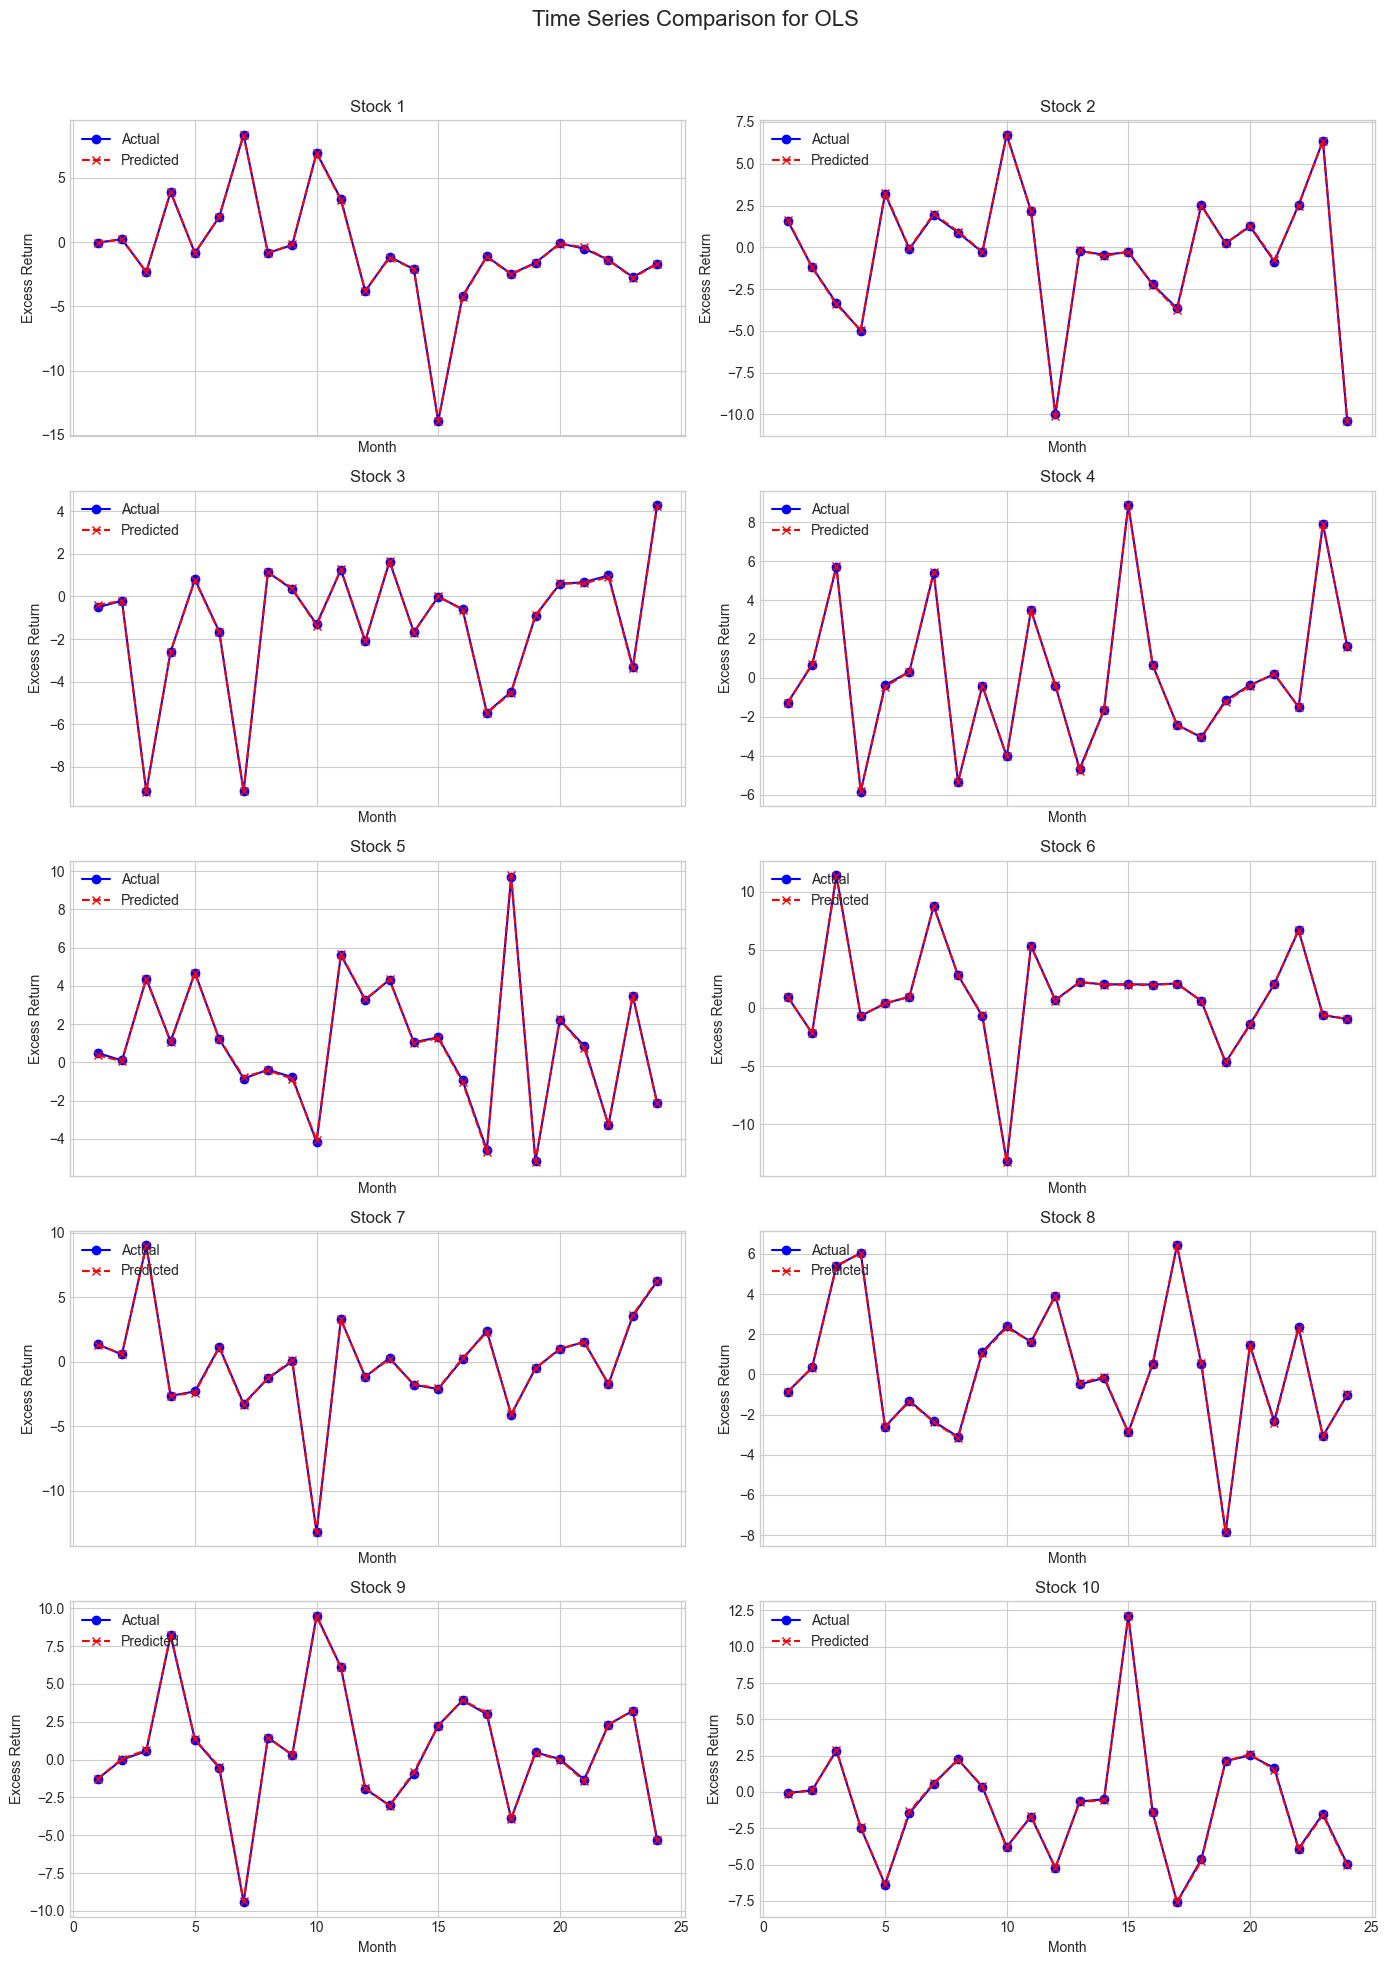

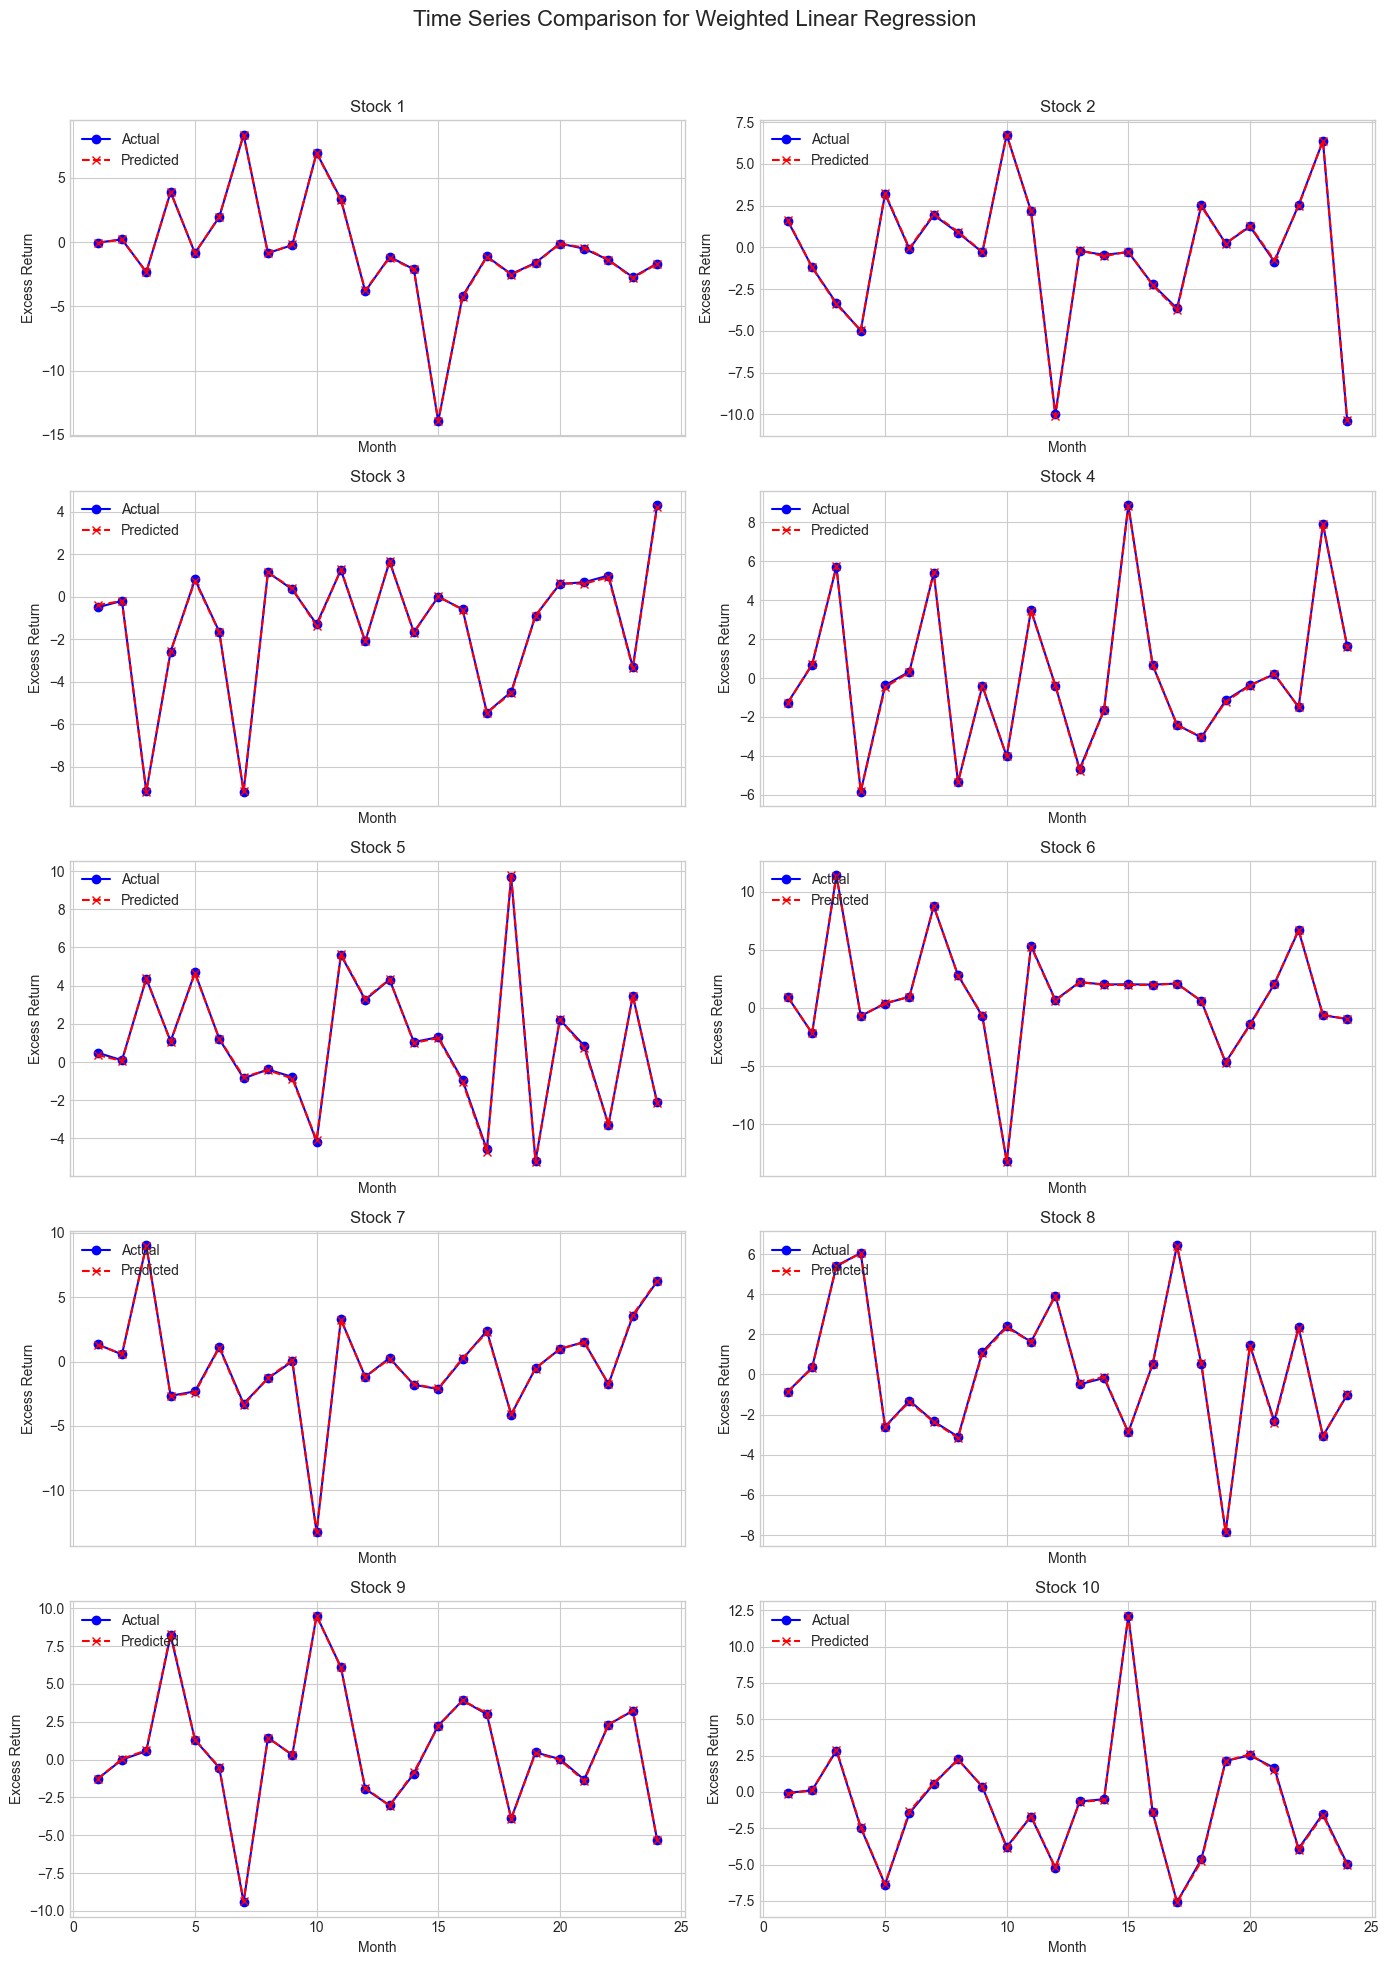

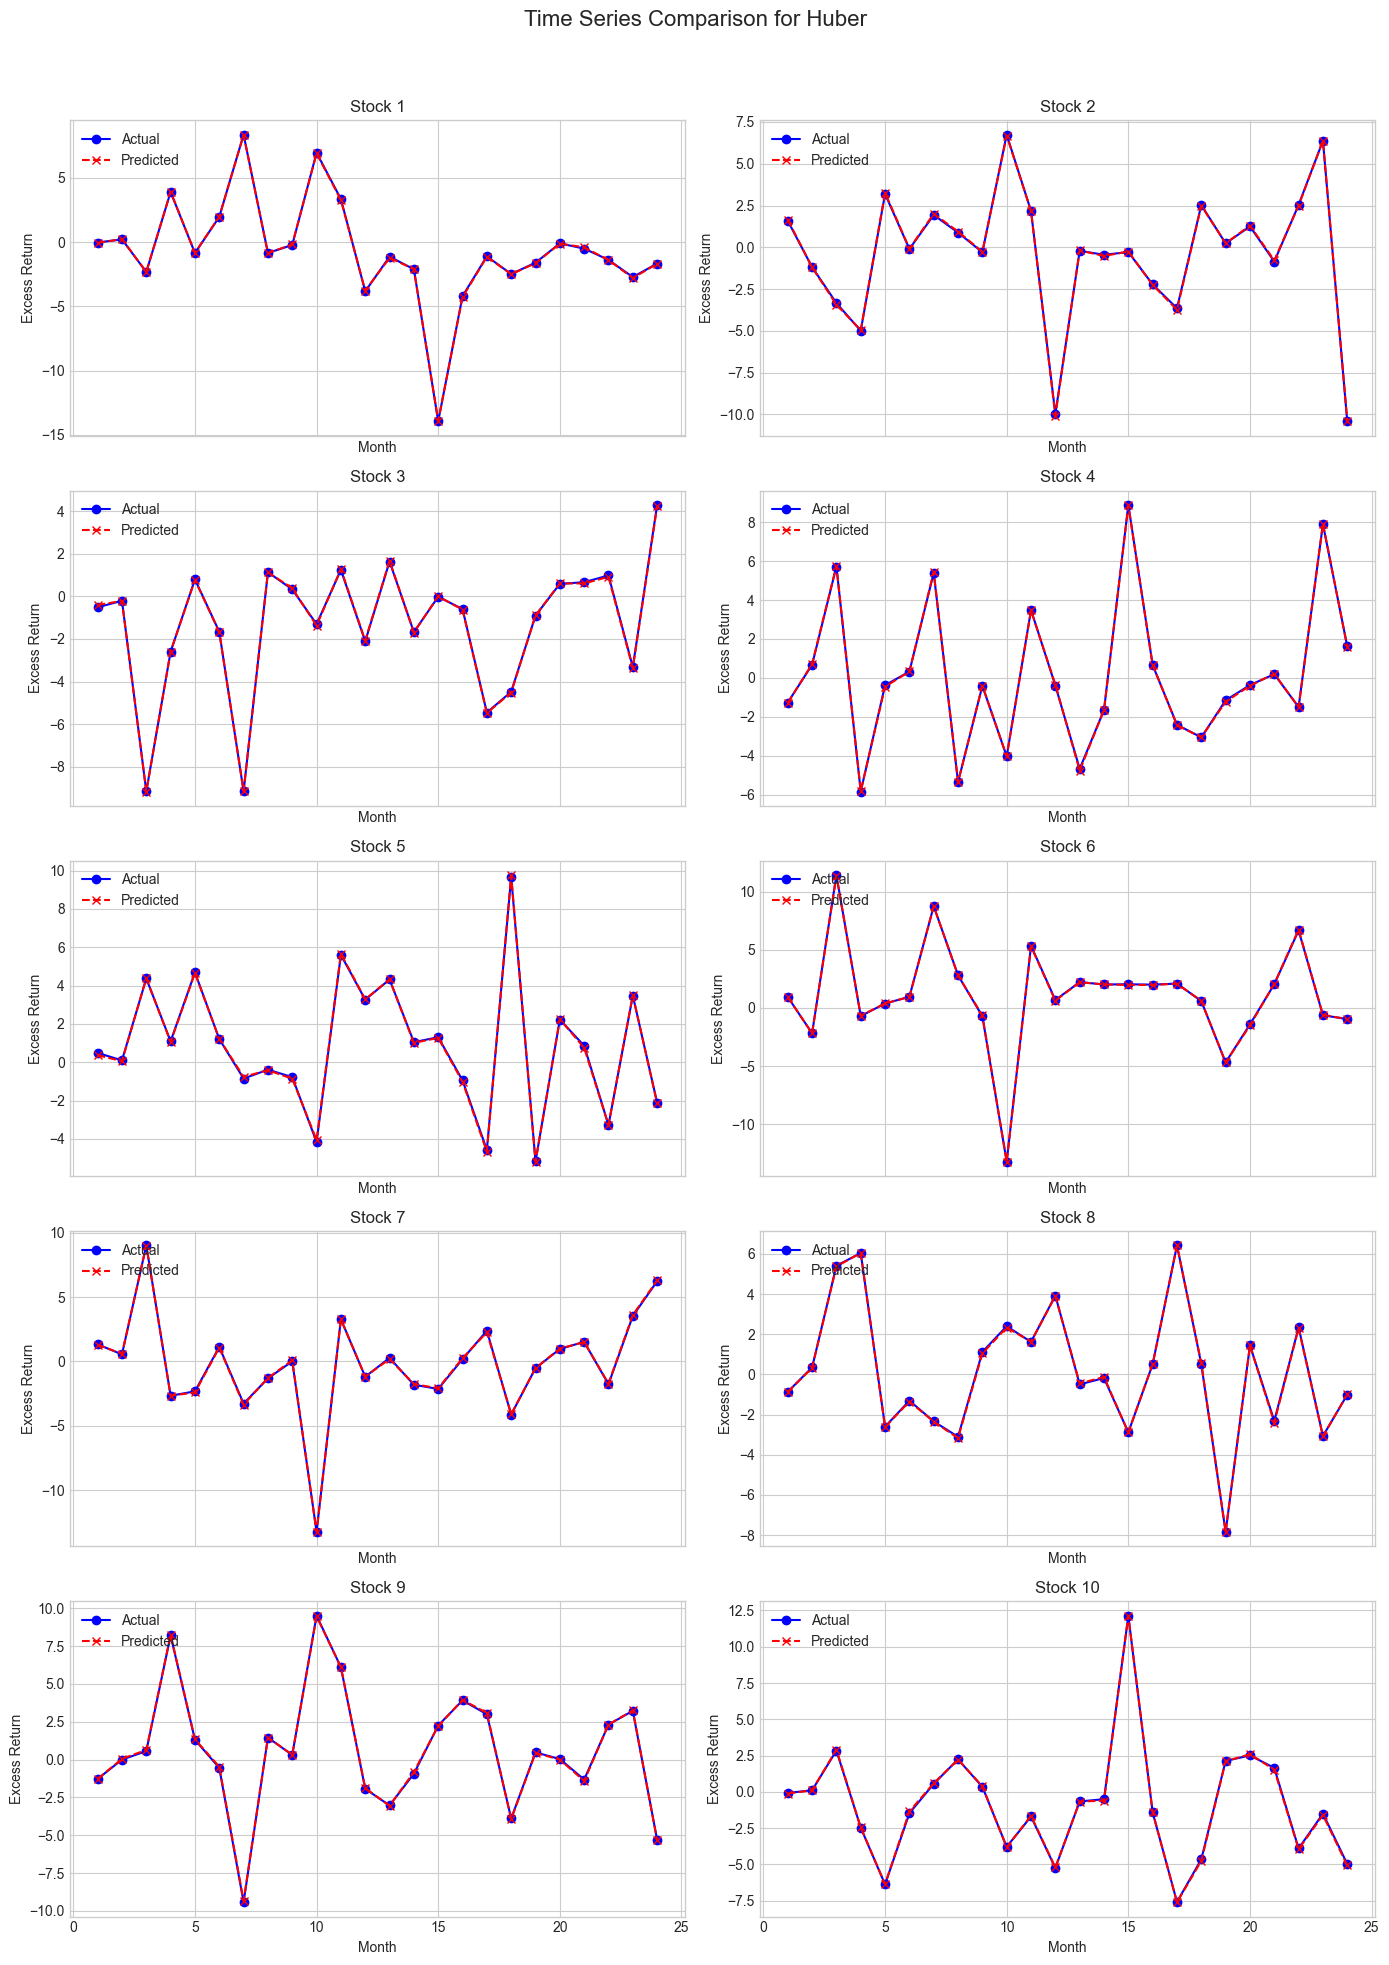

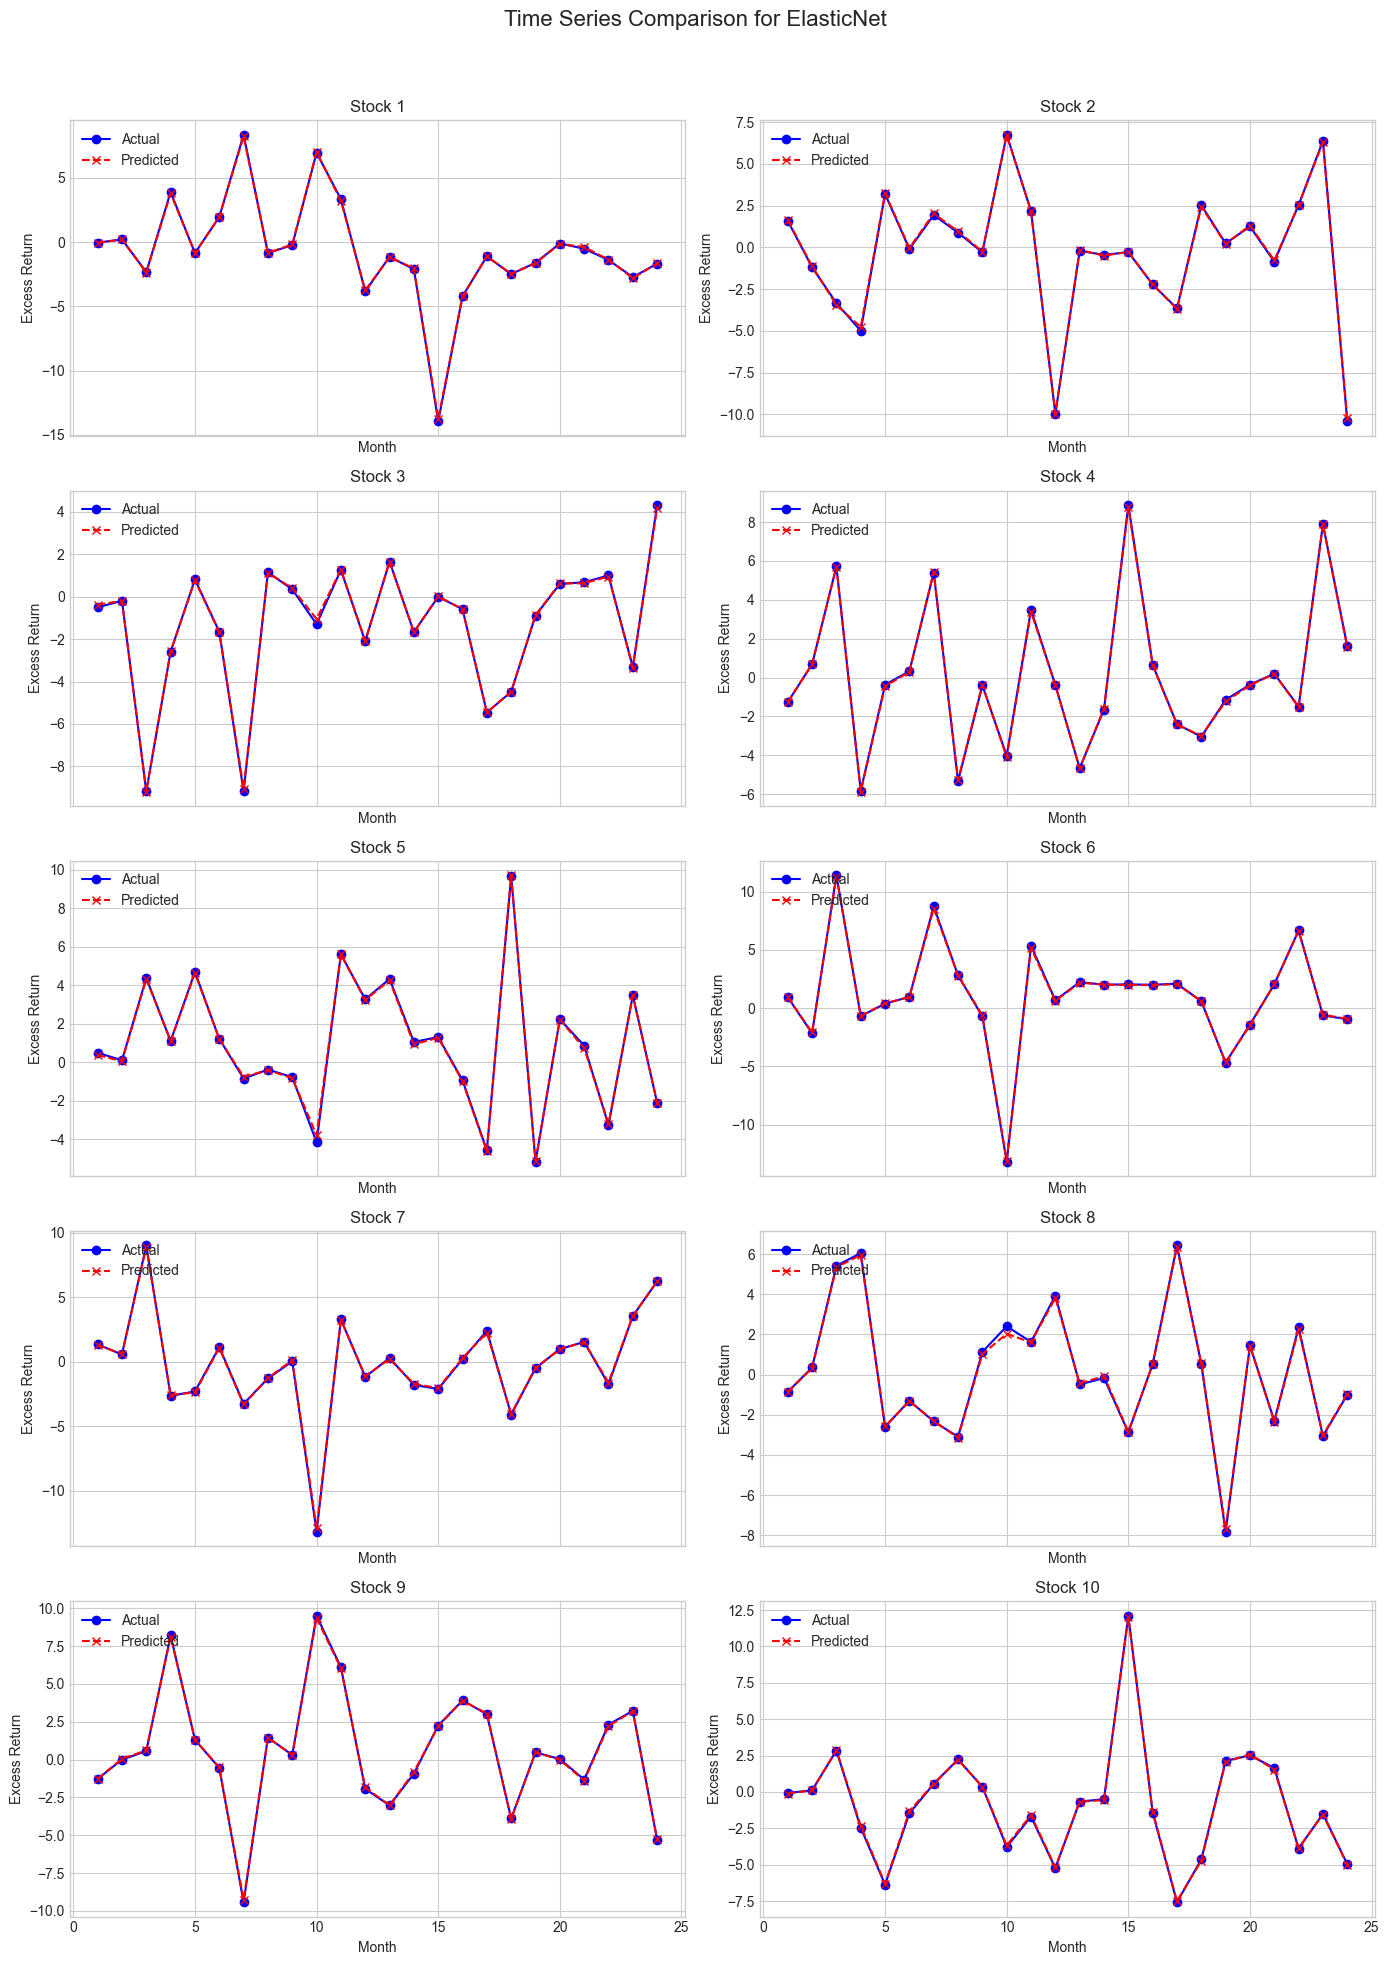

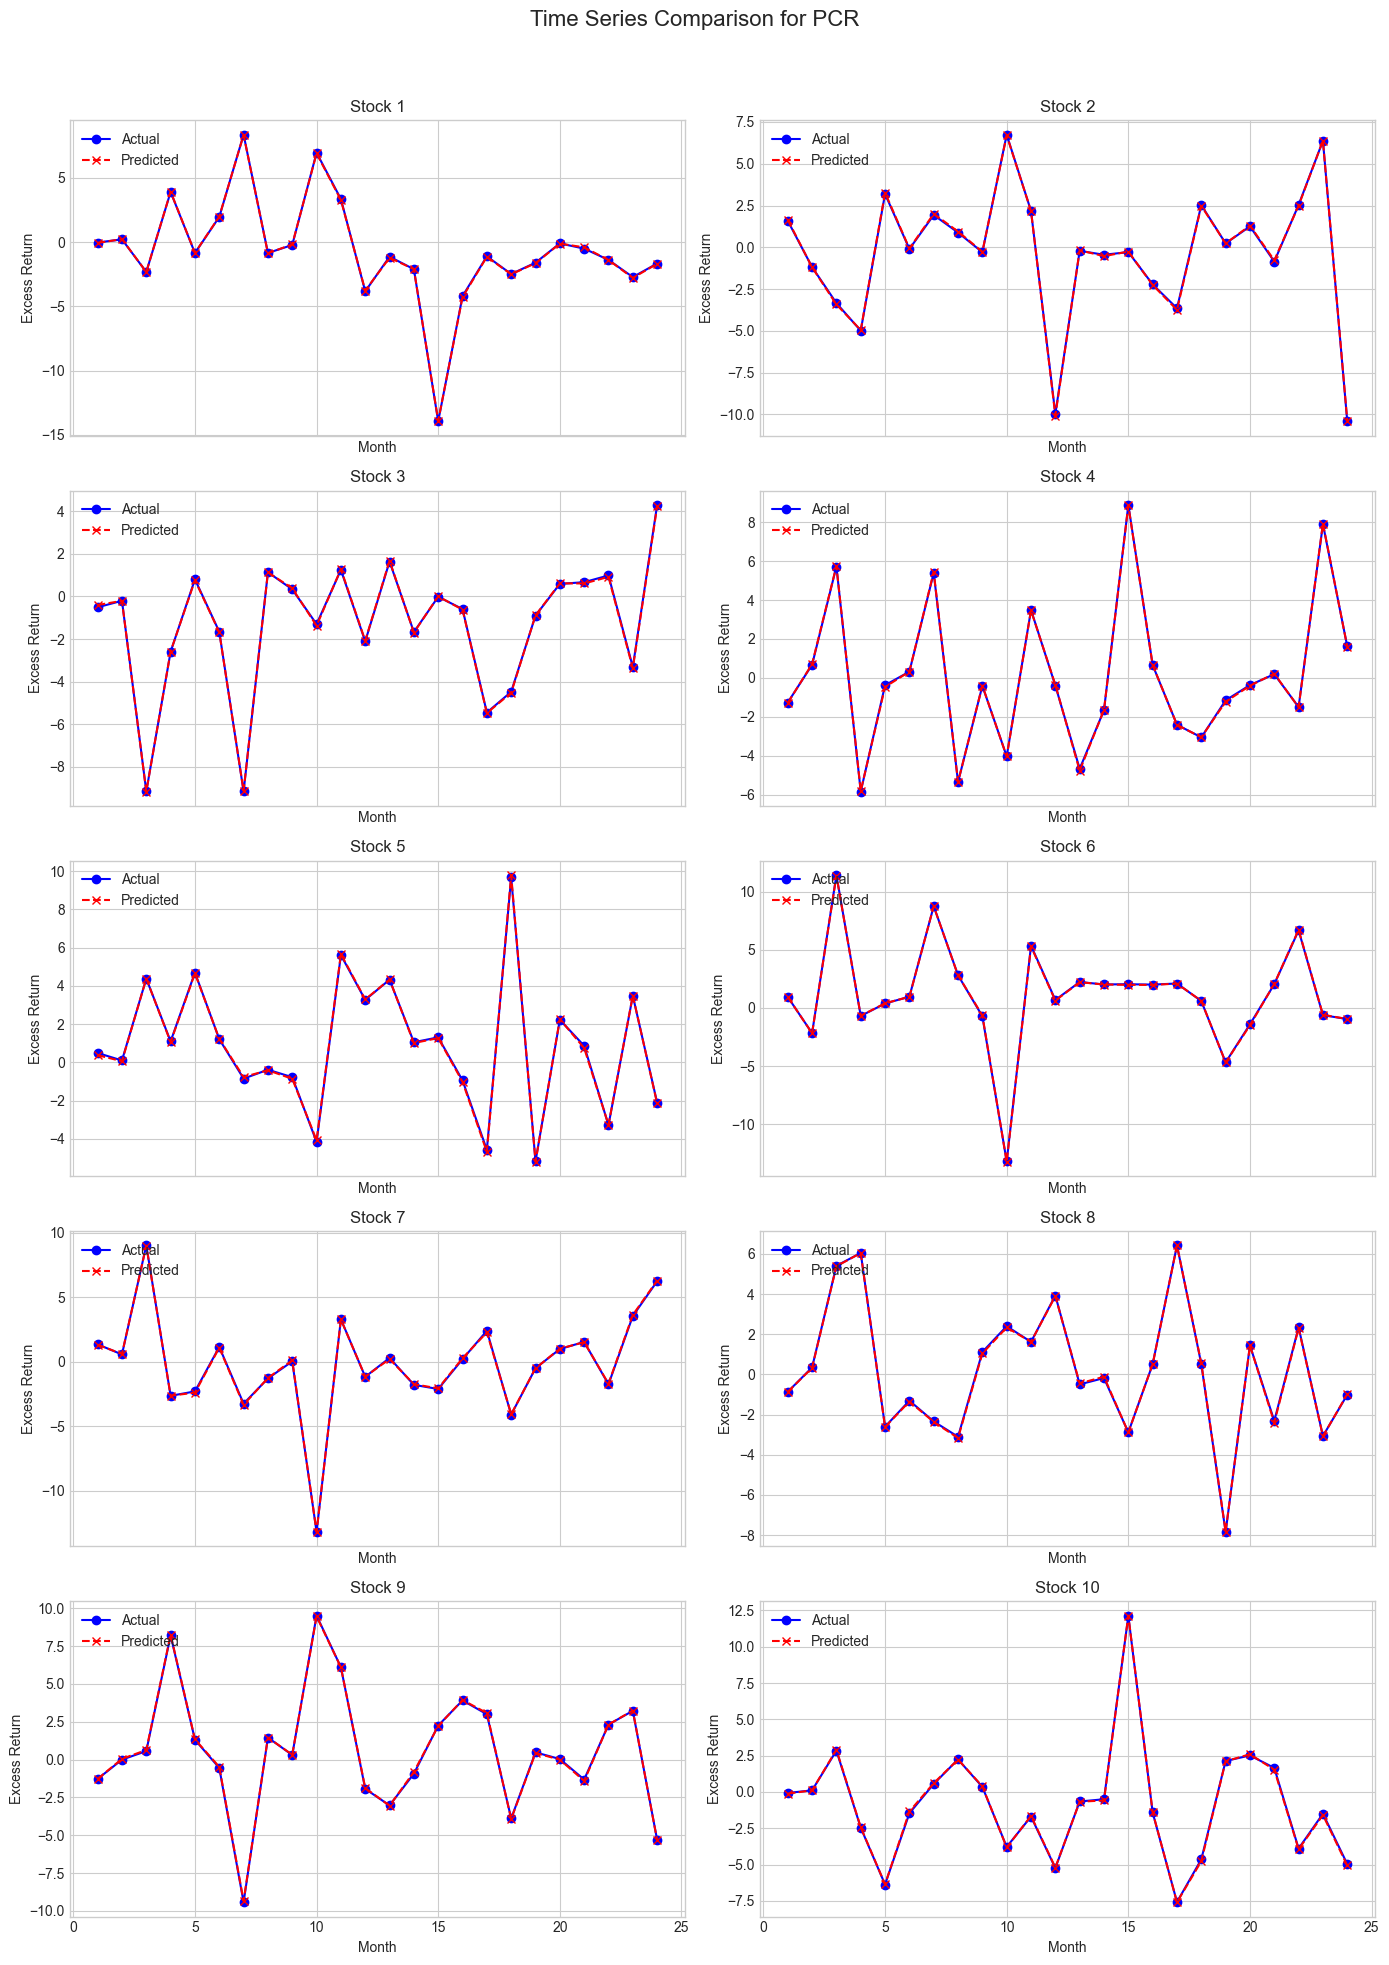

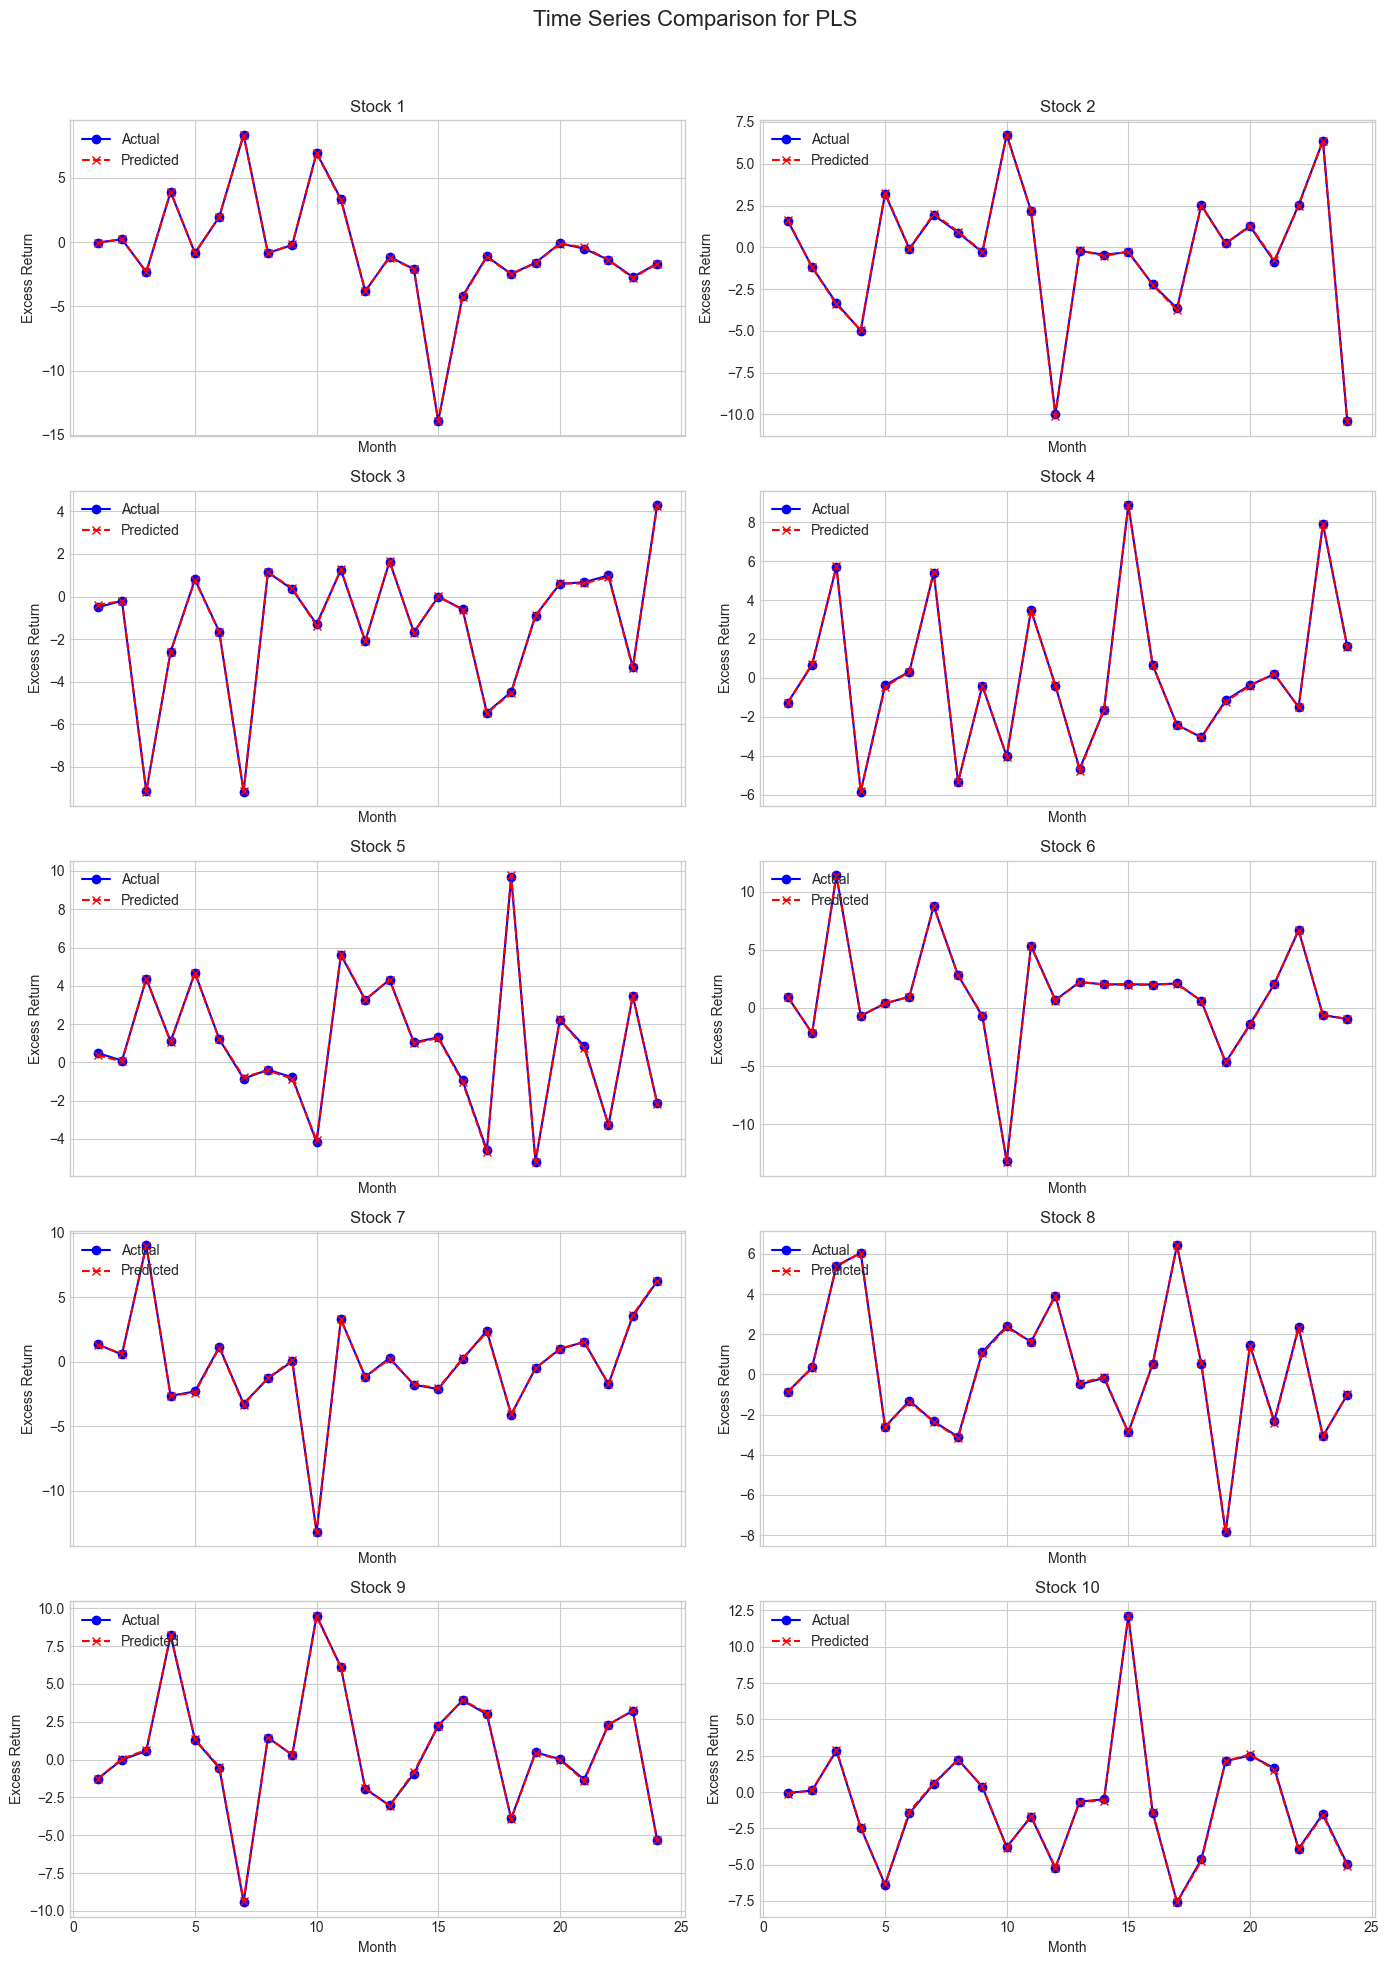

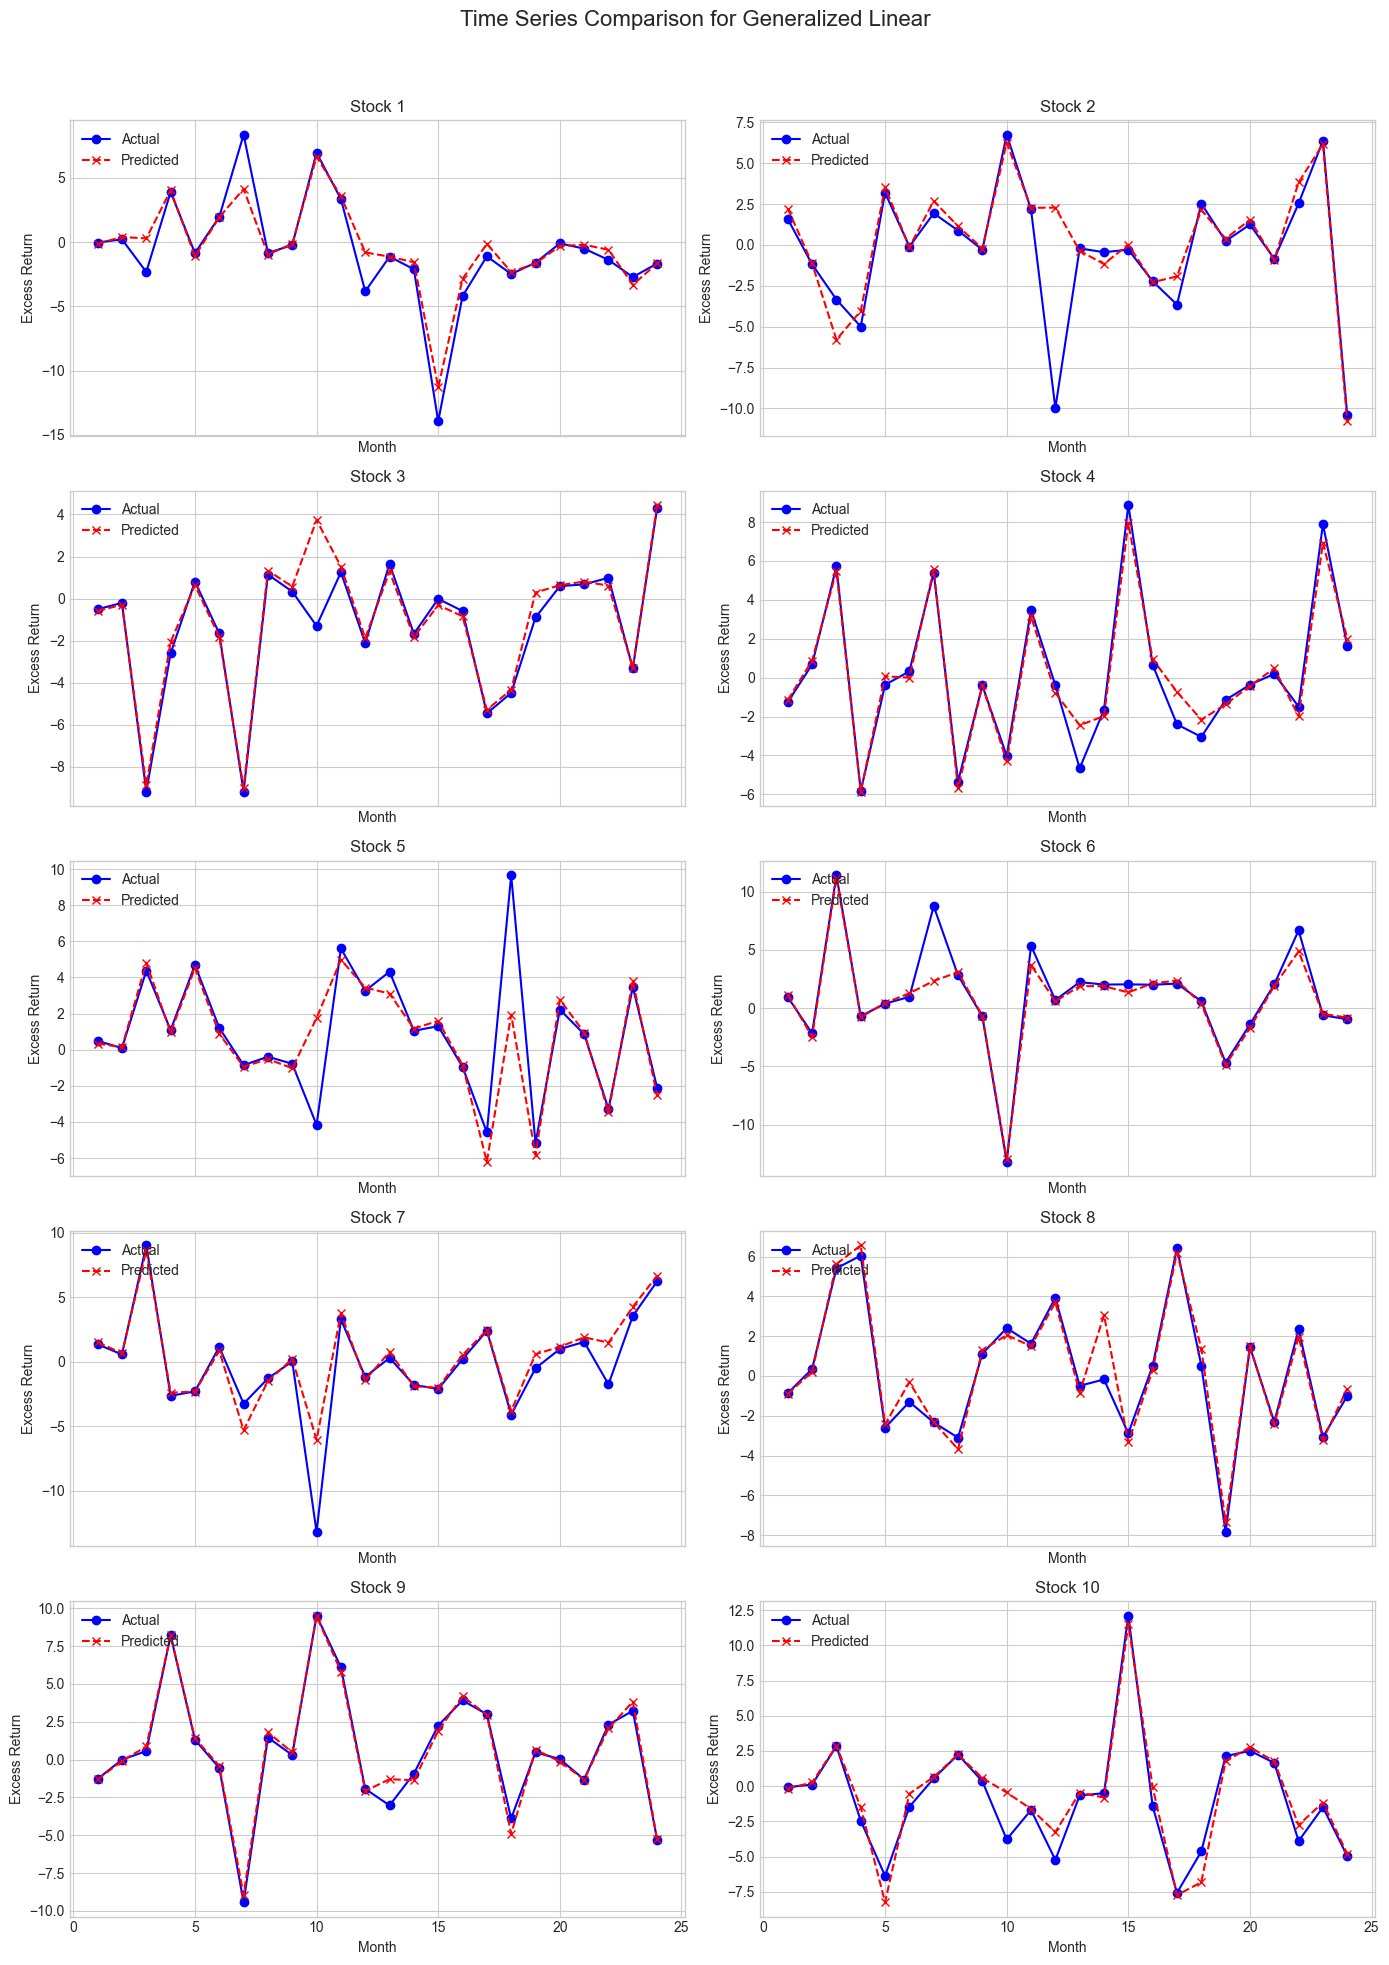

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


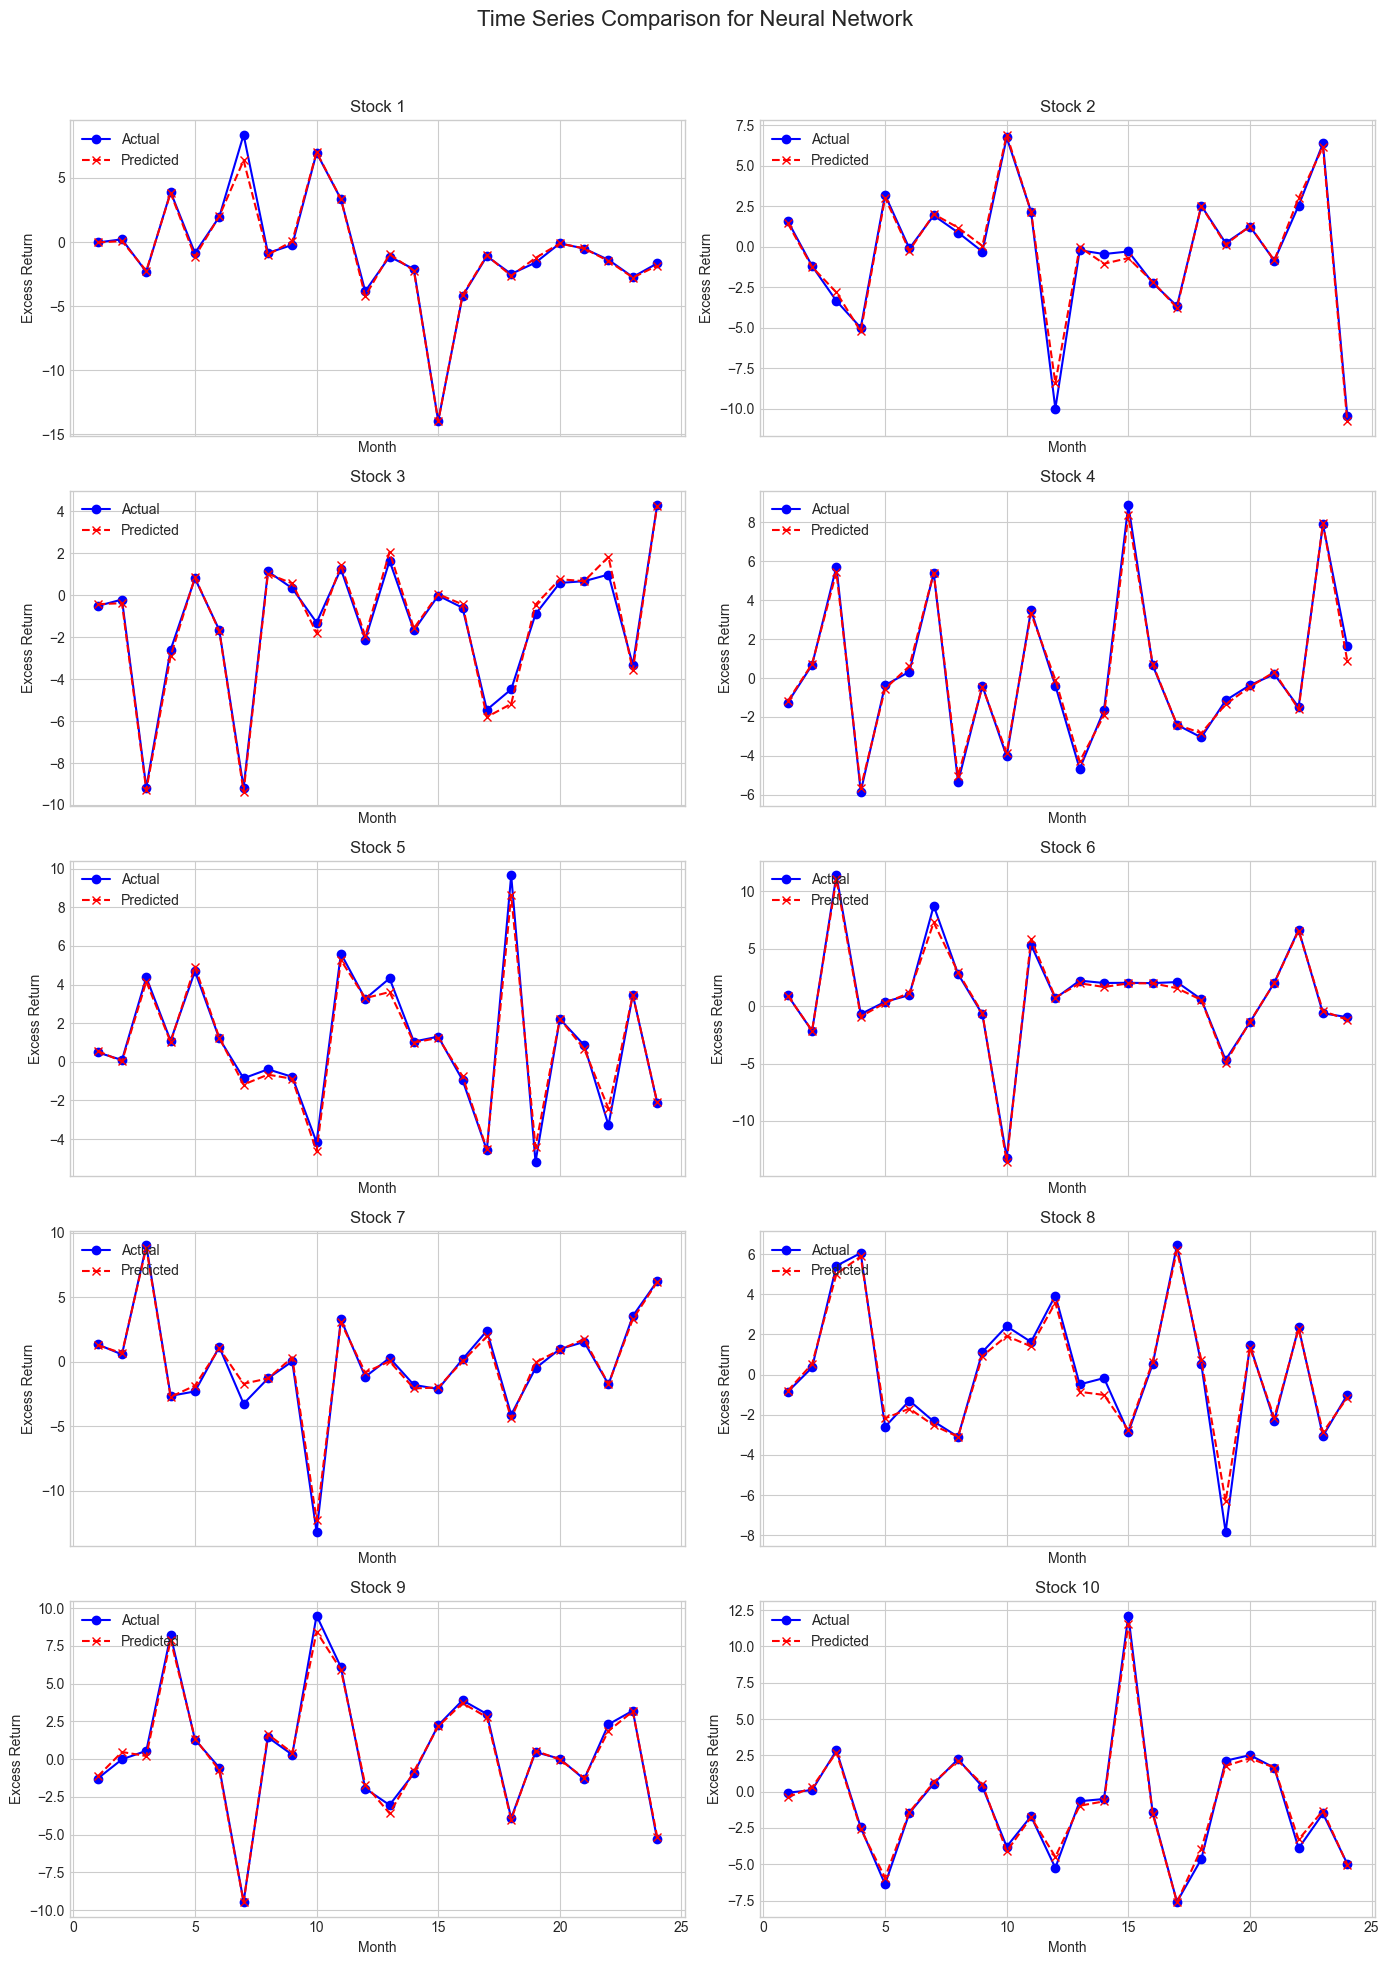

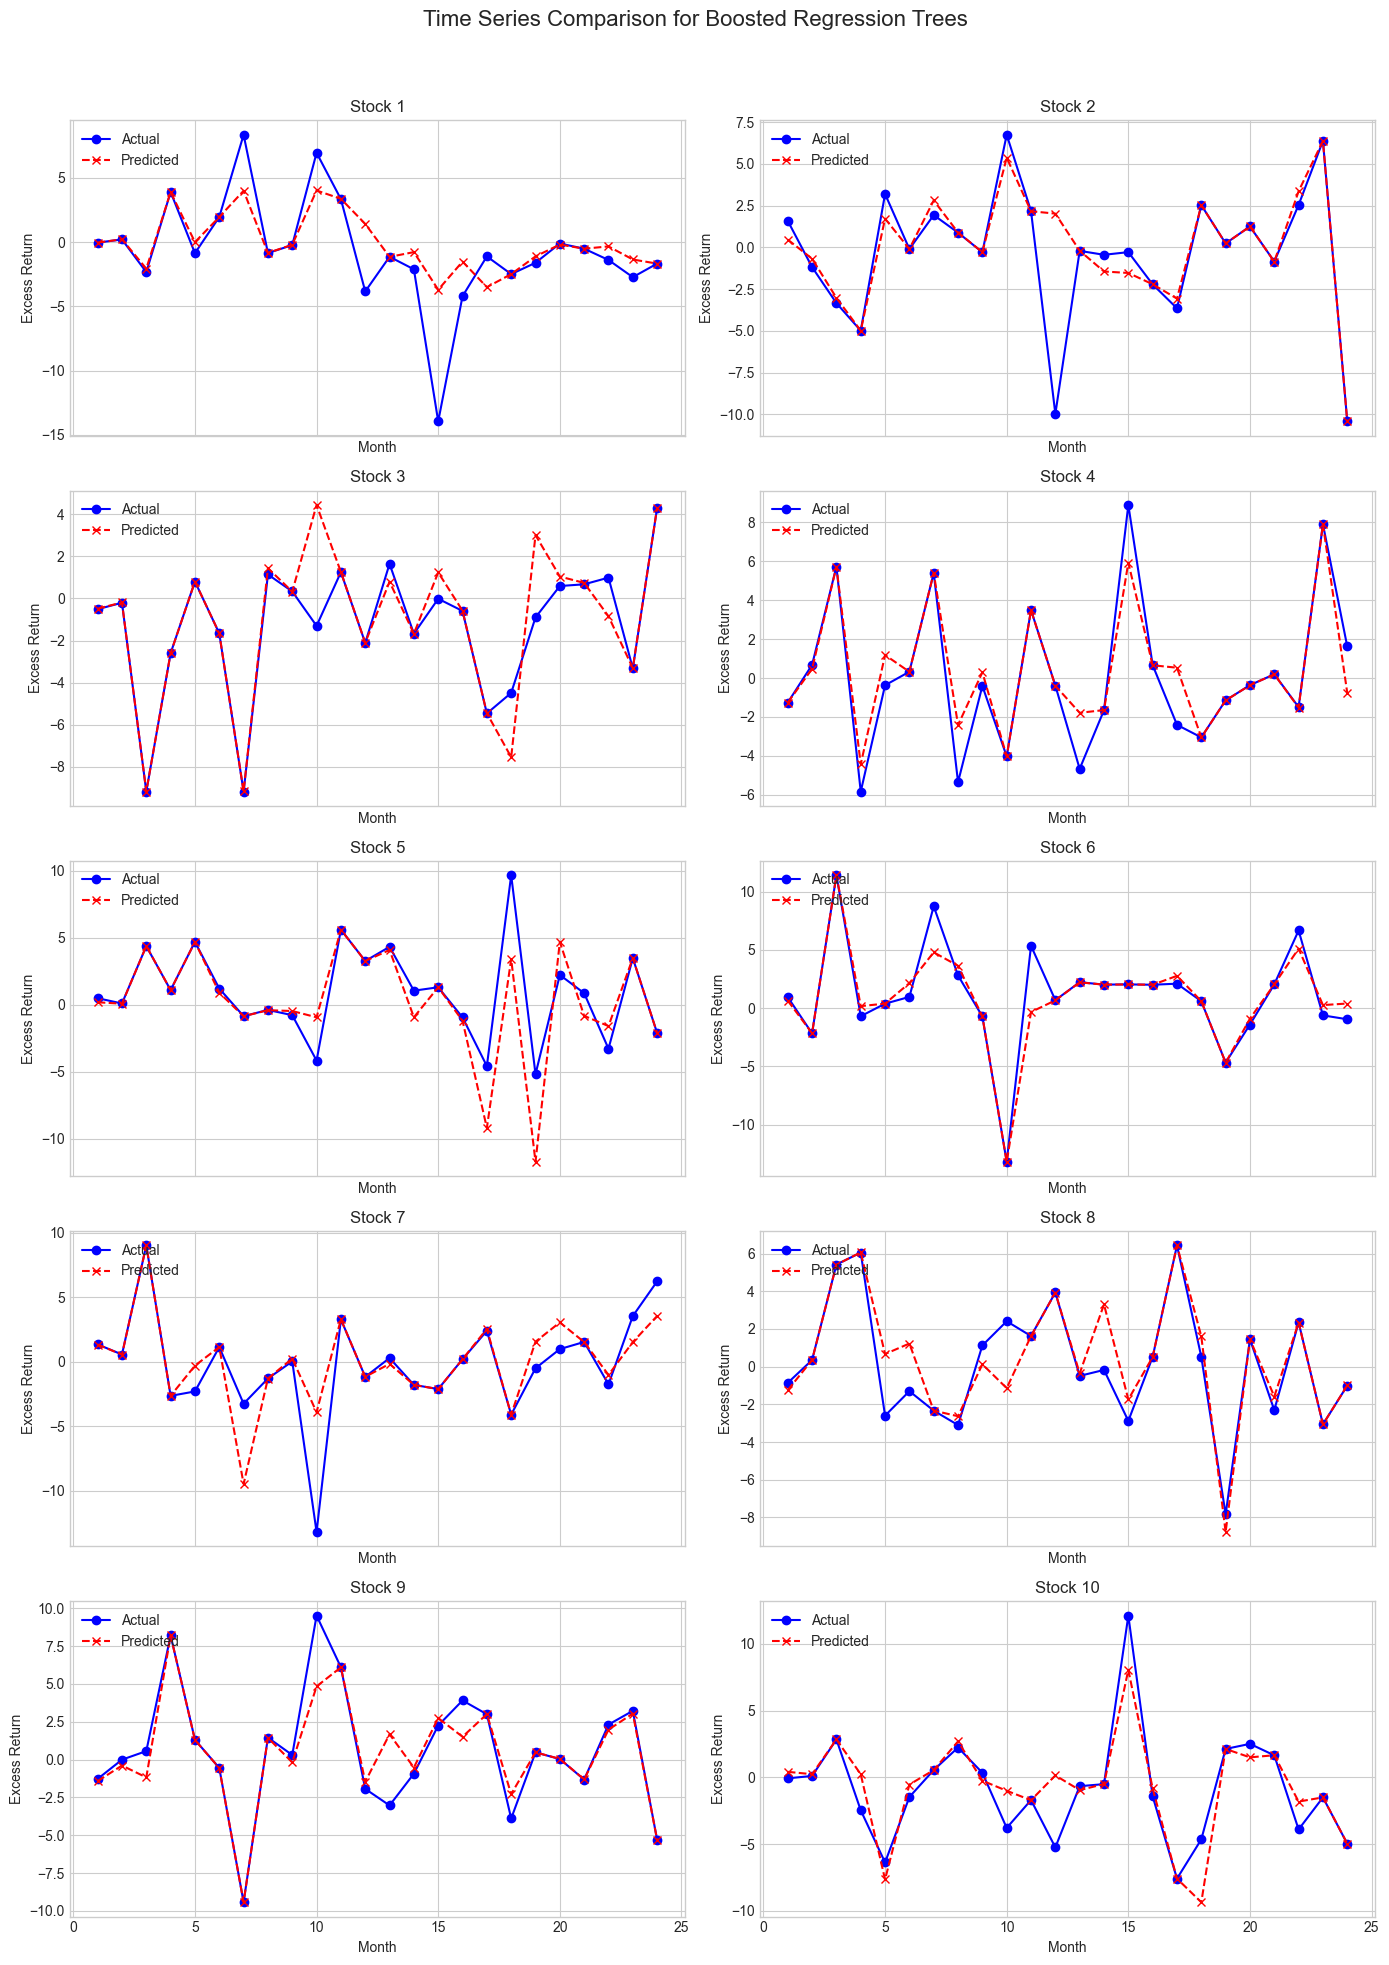

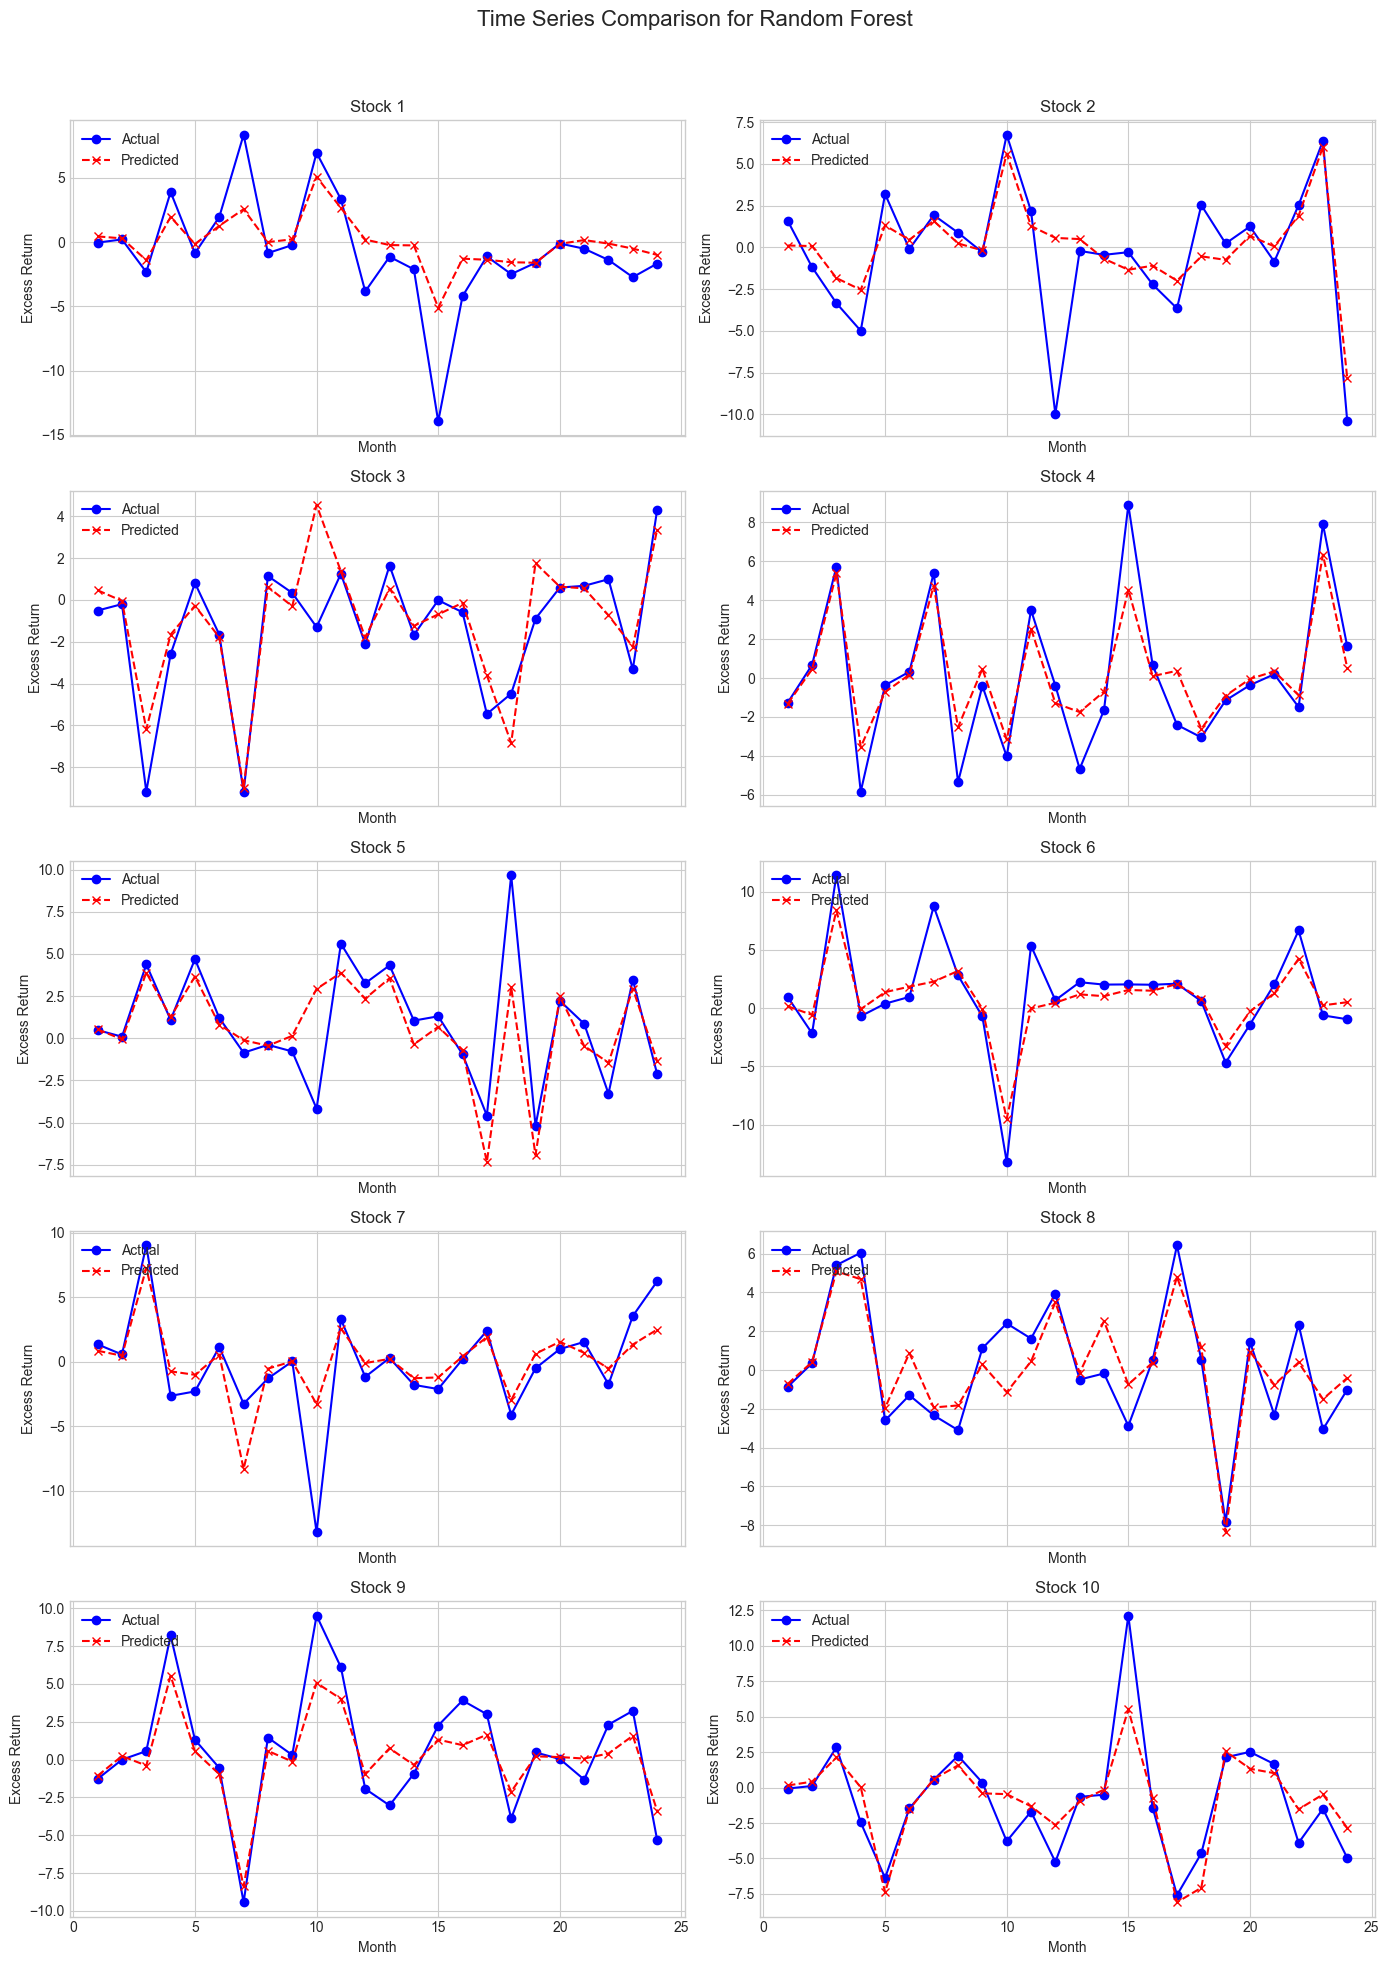

In [6]:
X_full = zi_t_flattened  # Assign the full feature dataset for prediction
actual_full = ri_t_plus_1  # Assign the full set of actual excess returns for comparison
months = np.arange(1, n_months + 1)  # Create an array of month numbers from 1 to n_months
for model_name, pred_func in full_model_predictors.items():  # Iterate over each model and its prediction function
    y_pred_full = pred_func(X_full).reshape(n_stocks, n_months)  # Predict for the full sample and reshape the results to (n_stocks, n_months)
    fig, axs = plt.subplots(5, 2, figsize=(14, 20), sharex=True)  # Create a 5x2 grid of subplots for plotting time series
    axs = axs.flatten()  # Flatten the subplot array for easier iteration
    for stock in range(n_stocks):  # Iterate over each stock
        ax = axs[stock]  # Select the current subplot axis for the stock
        ax.plot(months, actual_full[stock], label="Actual", marker='o', color="blue")  # Plot the actual excess return time series
        ax.plot(months, y_pred_full[stock], label="Predicted", marker='x', linestyle="--", color="red")  # Plot the predicted excess return time series
        ax.set_title(f"Stock {stock + 1}")  # Set the title of the subplot indicating the stock number
        ax.set_xlabel("Month")  # Label the x-axis as "Month"
        ax.set_ylabel("Excess Return")  # Label the y-axis as "Excess Return"
        ax.legend(loc='upper left')  # Add a legend to the subplot at the upper left position
    fig.suptitle(f"Time Series Comparison for {model_name}", fontsize=16)  # Set a super title for the figure with the model name
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to prevent overlapping and ensure the title is visible
    plt.show()  # Display the figure
    

# Part 7: Out-of-Sample R² Results Table

In [7]:
# TODO: Calculate R² according to the formula: 1 - (sum of squared errors / total sum of squares)
def r2_oos(y_true, y_pred):                     # Define a function to calculate the out-of-sample R² metric
    ss_res = np.sum((y_true - y_pred) ** 2)  
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Variance
    return 1 - ss_res / ss_tot 

r2_results = pd.DataFrame({  # Create a DataFrame to store the out-of-sample R² results for each model
    "Model": ["OLS", "Weighted Linear Regression", "Huber", "ElasticNet", "PCR", "PLS",
              "Generalized Linear", "Neural Network", "Boosted Regression Trees", "Random Forest"],  # List of model names
    "Out-of-Sample R²": [  # List of computed R² values for each model
        r2_oos(y_test, y_pred_ols),
        r2_oos(y_test, y_pred_weighted),
        r2_oos(y_test, y_pred_huber),
        r2_oos(y_test, y_pred_elasticnet),
        r2_oos(y_test, y_pred_pcr),
        r2_oos(y_test, y_pred_pls),
        r2_oos(y_test, y_pred_generalized),
        r2_oos(y_test, y_pred_nn),
        r2_oos(y_test, y_pred_brt),
        r2_oos(y_test, y_pred_rf)
    ]
})
print("Out-of-Sample R² Results:")  # Print a header for the R² results
print(r2_results)  # Print the DataFrame with R² results
print("\n")  # Print a newline for spacing


Out-of-Sample R² Results:
                        Model  Out-of-Sample R²
0                         OLS          0.999827
1  Weighted Linear Regression          0.999811
2                       Huber          0.999834
3                  ElasticNet          0.999510
4                         PCR          0.999827
5                         PLS          0.999830
6          Generalized Linear          0.818431
7              Neural Network          0.981793
8    Boosted Regression Trees          0.571476
9               Random Forest          0.613932




# Part 8: Diebold-Mariano Test Statistics

In [8]:
errors_dict = {  # Create a dictionary to store prediction errors for each model
    "OLS": y_test - y_pred_ols,     # Compute errors for the OLS model by subtracting predictions from actual values
    "Weighted": y_test - y_pred_weighted,    # Compute errors for the Weighted Linear Regression model
    "Huber": y_test - y_pred_huber,   # Compute errors for the Huber Regressor
    "ElasticNet": y_test - y_pred_elasticnet,   # Compute errors for the ElasticNet model
    "PCR": y_test - y_pred_pcr,    # Compute errors for the PCR model
    "PLS": y_test - y_pred_pls,    # Compute errors for the PLS model
    "Generalized": y_test - y_pred_generalized,    # Compute errors for the Generalized Linear model
    "Neural Network": y_test - y_pred_nn,   # Compute errors for the Neural Network model
    "BRT": y_test - y_pred_brt,    # Compute errors for the Boosted Regression Trees model
    "Random Forest": y_test - y_pred_rf    # Compute errors for the Random Forest model
}

def newey_west_se(data, lag=1):  # Define a function to compute the Newey-West standard error for a series of data with a specified lag
    n = len(data)  # Get the number of data points
    gamma = [np.sum((data[:n - i] - np.mean(data)) * (data[i:] - np.mean(data))) / n for i in range(lag + 1)]  # Compute autocovariances for lags 0 to 'lag'
    nw_var = gamma[0] + 2 * sum((1 - i / (lag + 1)) * gamma[i] for i in range(1, lag + 1))  # Compute the Newey-West variance estimate using weighted autocovariances
    return np.sqrt(nw_var / n)  # Return the Newey-West standard error by taking the square root of the variance estimate divided by n

model_names = list(errors_dict.keys())  # Extract the list of model names from the errors dictionary
dm_matrix = pd.DataFrame(index=model_names, columns=model_names, dtype=float)  # Create an empty DataFrame to store pairwise Diebold-Mariano test statistics
for i in range(len(model_names)):  # Loop over each model index for the first model in the pair
    for j in range(i + 1, len(model_names)):  # Loop over each subsequent model index to form unique pairs
        # TODO: Calculate the difference between the squared errors of two models (model1 minus model2) for the Diebold-Mariano test, to analyze which model's error is smaller
        model1 = model_names[i]
        model2 = model_names[j]
        e1_squared = errors_dict[model1] ** 2
        e2_squared = errors_dict[model2] ** 2
        d12_t = e1_squared - e2_squared # Your code here

        # Compute the mean difference in squared errors between the two models
        mean_d12 = np.mean(d12_t)
        # Compute the Newey-West standard error for the difference series
        se_d12 = newey_west_se(d12_t)
        # Calculate the Diebold-Mariano (DM) statistic (by dividing the computed mean_d12 by its standard error se_d12)
        DM_stat = mean_d12 / se_d12
        dm_matrix.loc[model1, model2] = DM_stat  # Store the DM statistic in the matrix for (model1, model2)
        dm_matrix.loc[model2, model1] = -DM_stat  # Store the negative DM statistic for (model2, model1) to reflect the reversal in differences
print("Diebold-Mariano Test Statistics (pairwise comparisons):")  # Print a header for the DM test statistics
print(dm_matrix)  # Print the DataFrame containing pairwise DM test statistics
print("\n")  # Print a newline for spacing



Diebold-Mariano Test Statistics (pairwise comparisons):
                     OLS  Weighted     Huber  ElasticNet       PCR       PLS  \
OLS                  NaN -2.019386  1.584534   -2.433050 -1.260204  1.253389   
Weighted        2.019386       NaN  2.120683   -2.293808  2.019386  1.970889   
Huber          -1.584534 -2.120683       NaN   -2.510848 -1.584534 -1.139450   
ElasticNet      2.433050  2.293808  2.510848         NaN  2.433050  2.462374   
PCR             1.260204 -2.019386  1.584534   -2.433050       NaN  1.253389   
PLS            -1.253389 -1.970889  1.139450   -2.462374 -1.253389       NaN   
Generalized     2.620909  2.620700  2.620955    2.617685  2.620909  2.620959   
Neural Network  4.146595  4.143718  4.147729    4.094790  4.146595  4.147344   
BRT             4.769250  4.769226  4.769244    4.768063  4.769250  4.769247   
Random Forest   3.759873  3.759754  3.759903    3.758848  3.759873  3.759901   

                Generalized  Neural Network       BRT  Random F

# Part 9: Variable Importance Calculations & Heatmaps

Variable Importance for OLS:
     Feature  R2 Importance  SSD Importance
0  Feature 1       0.050359        0.076440
1  Feature 2       0.006790        0.006301
2  Feature 3       0.058967        0.092843
3  Feature 4       0.001406        0.001253
4  Feature 5       0.493803        0.344489 

Variable Importance for Weighted Linear Regression:
     Feature  R2 Importance  SSD Importance
0  Feature 1       0.050557        0.076122
1  Feature 2       0.006743        0.006223
2  Feature 3       0.059193        0.093539
3  Feature 4       0.001388        0.001160
4  Feature 5       0.492675        0.343599 

Variable Importance for Huber:
     Feature  R2 Importance  SSD Importance
0  Feature 1       0.050417        0.076407
1  Feature 2       0.006769        0.006326
2  Feature 3       0.058799        0.092618
3  Feature 4       0.001431        0.001300
4  Feature 5       0.494067        0.344046 

Variable Importance for ElasticNet:
     Feature  R2 Importance  SSD Importance
0  Feature

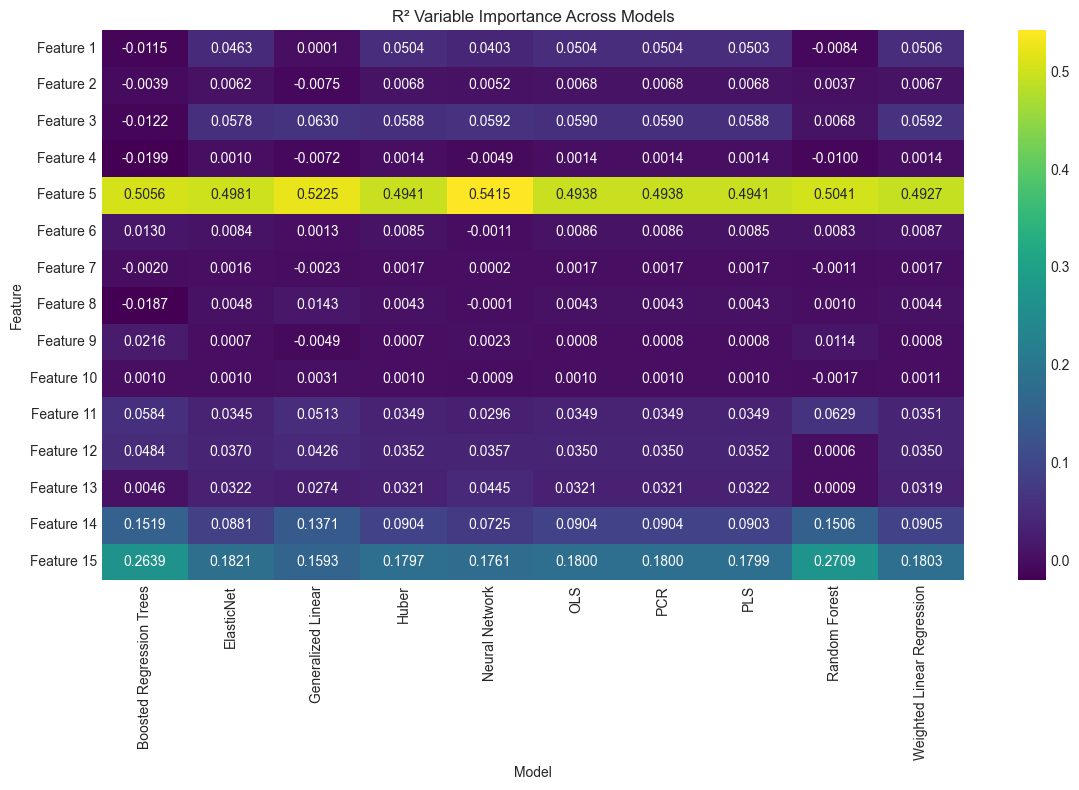

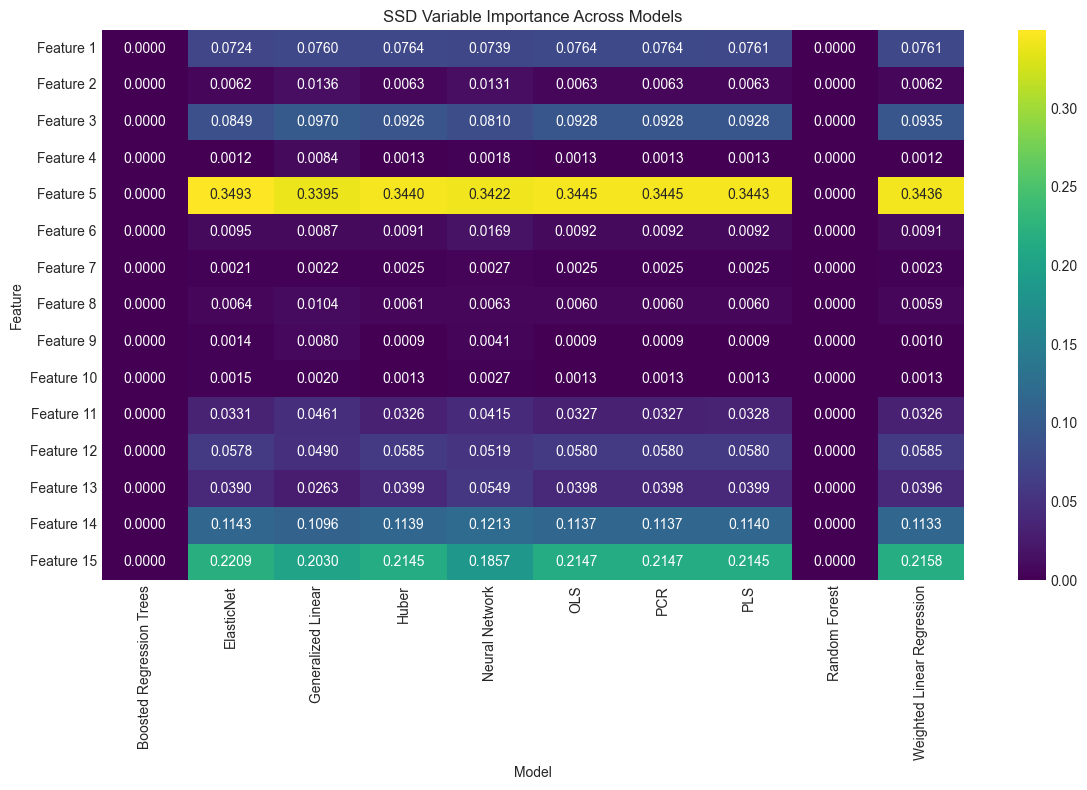

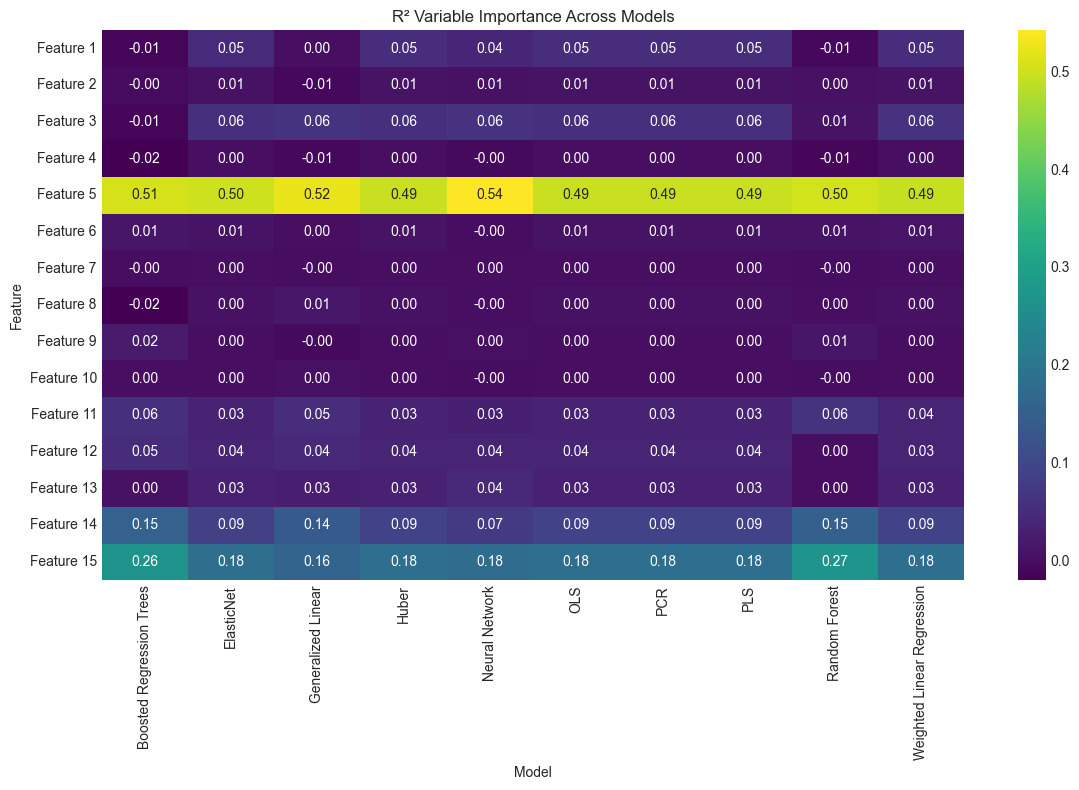

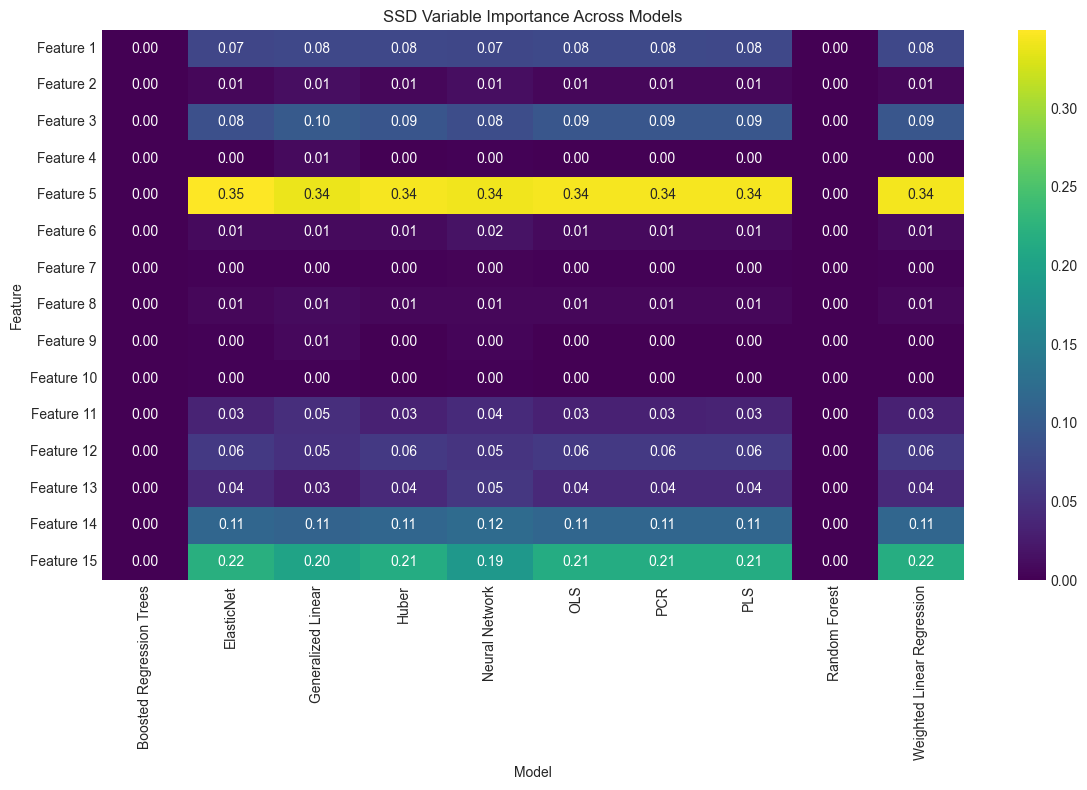

In [17]:

def compute_r2_importance(predict_func, X_test, y_test):  # Define a function to compute variable importance based on the drop in R² when a feature is removed
    # Compute the full model R² score on the test set
    r2_full = r2_score(y_test, predict_func(X_test))
    importances = []  # Initialize a list to store importance values for each feature
    
    for j in range(X_test.shape[1]):     # Loop over each feature index
        X_test_modified = X_test.copy()  # Create a copy of the test set to modify
        X_test_modified[:, j] = 0        # Set all values in the j-th column (i.e., the j-th feature) of the copy to 0, simulating the removal of that feature's contribution to the model prediction
       
        
        # Use the prediction function predict_func on the modified test data X_test_modified to obtain predictions when the j-th feature is removed
        y_pred_modified = predict_func(X_test_modified)
        # Calculate the R² value (r2_modified) for the predictions on the modified data, which measures the model performance after removing that feature
        r2_modified = r2_score(y_test, y_pred_modified)
        # Compute the difference between the full model's R² and the modified model's R² (r2_full - r2_modified) and append this difference to the importances list
        importance = r2_full - r2_modified
        importances.append(importance)

    importances = np.array(importances)  # Convert the list of importances to a NumPy array
    if importances.sum() != 0:  # If the total importance is not zero
        importances /= importances.sum()  # Normalize the importances so that they sum to 1
    return importances  # Return the normalized variable importances

# Define a function to compute variable importance using the Sum of Squared Derivatives (SSD) approach
def compute_ssd_importance(predict_func, X_train, epsilon=1e-5):  # Define a function to compute SSD importance with a small perturbation epsilon
    ssd_importance = []  # Initialize a list to store SSD importance for each feature
    for j in range(X_train.shape[1]):  # Loop over each feature index
        partial_derivatives = []  # Initialize a list to store partial derivatives for each sample
        for i in range(X_train.shape[0]):  # Loop over each sample
            X_train_plus = X_train.copy()  # Create a copy of X_train for positive perturbation
            X_train_minus = X_train.copy()  # Create a copy of X_train for negative perturbation
            # Add a small perturbation epsilon to the feature value at row i, column j of the copy X_train_plus, simulating a positive change
            X_train_plus[i, j] += epsilon
            # Subtract epsilon from the feature value at row i, column j of the copy X_train_minus, simulating a negative change
            X_train_minus[i, j] -= epsilon
            # Use the modified X_train_plus as input to call the prediction function and obtain predictions y_plus
            y_plus = predict_func(X_train_plus)
            # Compute predictions with negatively perturbed data
            y_minus = predict_func(X_train_minus)
            # Calculate the numerical gradient (approximate partial derivative) for sample i with respect to feature j using the central difference method: grad = (y_plus[i] - y_minus[i]) / (2 * epsilon)
            grad = (y_plus[i] - y_minus[i]) / (2 * epsilon)
            partial_derivatives.append(grad ** 2)  # Append the squared gradient to the list of partial derivatives
        ssd_importance.append(np.sum(partial_derivatives))  # Sum the squared gradients for feature j and append to the SSD importance list
    ssd_importance = np.array(ssd_importance)  # Convert the list to a NumPy array
    if ssd_importance.sum() != 0:  # If the sum of SSD importances is nonzero
        ssd_importance /= ssd_importance.sum()  # Normalize the SSD importances so that they sum to 1
    return ssd_importance  # Return the normalized SSD importances

models = {                                            # Create a dictionary mapping model names to their prediction functions for variable importance evaluation
    'OLS': predict_ols,                               # Map "OLS" to its prediction function
    'Weighted Linear Regression': predict_weighted,   # Map "Weighted Linear Regression" to its prediction function
    'Huber': predict_huber,                           # Map "Huber" to its prediction function
    'ElasticNet': predict_elasticnet,                 # Map "ElasticNet" to its prediction function
    'PCR': predict_pcr,                               # Map "PCR" to its prediction function
    'PLS': predict_pls,                               # Map "PLS" to its prediction function
    'Generalized Linear': predict_gen_linear,         # Map "Generalized Linear" to its prediction function
    'Neural Network': predict_nn,                     # Map "Neural Network" to its prediction function
    'Boosted Regression Trees': predict_brt,          # Map "Boosted Regression Trees" to its prediction function
    'Random Forest': predict_rf                       # Map "Random Forest" to its prediction function
}

importance_results = {}  # Initialize an empty dictionary to store variable importance results for each model
for model_name, predict_func in models.items():  # Loop over each model and its prediction function
    r2_imp = compute_r2_importance(predict_func, X_test, y_test)  # Compute the R²-based importance for the model
    ssd_imp = compute_ssd_importance(predict_func, X_train)  # Compute the SSD-based importance for the model
    importance_results[model_name] = {'R2 Importance': r2_imp, 'SSD Importance': ssd_imp}  # Store the importance results in the dictionary
    importance_df = pd.DataFrame({  # Create a DataFrame to display variable importance for the current model
        'Feature': [f'Feature {j + 1}' for j in range(X_train.shape[1])],  # Create feature labels for each column
        'R2 Importance': r2_imp,  # Add the R²-based importance values
        'SSD Importance': ssd_imp  # Add the SSD-based importance values
    })
    print(f"Variable Importance for {model_name}:")  # Print a header with the model name
    print(importance_df.head(), "\n")  # Print the first few rows of the importance DataFrame with spacing
all_importance = []  # Initialize a list to combine variable importance data from all models
for model_name, imps in importance_results.items():  # Loop over each model and its importance values
    for j in range(X_train.shape[1]):  # Loop over each feature index
        all_importance.append({  # Append a dictionary with model and feature importance details to the list
            'Model': model_name,  # Specify the model name
            'Feature': f'Feature {j + 1}',  # Specify the feature name
            'R2 Importance': imps['R2 Importance'][j],  # Add the R²-based importance for the feature
            'SSD Importance': imps['SSD Importance'][j]  # Add the SSD-based importance for the feature
        })
all_importance_df = pd.DataFrame(all_importance)  # Convert the list of combined importances into a DataFrame
print("Combined Variable Importance (first few rows):")  # Print a header for the combined variable importance
print(all_importance_df.head())  # Print the first few rows of the combined variable importance DataFrame
feature_order = [f'Feature {i}' for i in range(1, 16)]  # Define a custom order for features for the heatmap (features 1 to 15)
r2_importance_df = all_importance_df.pivot(index='Feature', columns='Model', values='R2 Importance').reindex(feature_order)  # Create a pivot table for R² importance and reindex it based on feature_order
ssd_importance_df = all_importance_df.pivot(index='Feature', columns='Model', values='SSD Importance').reindex(feature_order)  # Create a pivot table for SSD importance and reindex it based on feature_order
plt.figure(figsize=(12, 8))  # Create a new figure for the R² importance heatmap
sns.heatmap(r2_importance_df, annot=True, cmap="viridis", fmt=".4f")  # Plot a heatmap for R² importance with annotations and a viridis color map
plt.title("R² Variable Importance Across Models")  # Set the title for the R² importance heatmap
plt.xlabel("Model")  # Label the x-axis as "Model"
plt.ylabel("Feature")  # Label the y-axis as "Feature"
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()  # Display the R² importance heatmap
plt.figure(figsize=(12, 8))  # Create a new figure for the SSD importance heatmap
sns.heatmap(ssd_importance_df, annot=True, cmap="viridis", fmt=".4f")  # Plot a heatmap for SSD importance with annotations and a viridis color map
plt.title("SSD Variable Importance Across Models")  # Set the title for the SSD importance heatmap
plt.xlabel("Model")  # Label the x-axis as "Model"
plt.ylabel("Feature")  # Label the y-axis as "Feature"
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()  # Display the SSD importance heatmap

# === R² HEATMAP ===
plt.figure(figsize=(12, 8))
sns.heatmap(r2_importance_df, annot=True, cmap="viridis", fmt=".2f")
plt.title("R² Variable Importance Across Models")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("r2_variable_importance.jpg", dpi=300)
plt.show()

# === SSD HEATMAP ===
plt.figure(figsize=(12, 8))
sns.heatmap(ssd_importance_df, annot=True, cmap="viridis", fmt=".2f")
plt.title("SSD Variable Importance Across Models")
plt.xlabel("Model")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("ssd_variable_importance.jpg", dpi=300)
plt.show()



# Part 10: Auxiliary Functions and Decile Portfolio Analysis

In [12]:

def assign_decile(x):  # Define a function to assign decile rankings to a Pandas Series
    if x.nunique() == 1:  # If the series contains only one unique value
        return pd.Series(1, index=x.index)  # Return a series where all entries are assigned decile 1
    else:
        ranks = x.rank(method='first')  # Rank the values in the series using the 'first' method to break ties
        n = len(x)  # Get the total number of elements in the series
        deciles = np.ceil((ranks * 10) / n).astype(int)  # Calculate deciles by scaling the ranks to a 1-10 range
        return deciles  # Return the computed decile rankings

def safe_div(x, y):  # Define a safe division function to avoid division by zero
    return x / y if y != 0 else np.nan  # Return x divided by y if y is nonzero; otherwise, return NaN

indices = np.arange(len(ri_t_flattened))  # Create an array of indices corresponding to each data point
_, test_indices = train_test_split(indices, test_size=0.3, random_state=42)  # Split indices into a test set (30%) and a training set (unused here)
ri_t_df_test = ri_t_df.iloc[test_indices].reset_index(drop=True)  # Create a test DataFrame by selecting rows corresponding to test_indices and reset the index

results = {}  # Initialize a dictionary to store decile portfolio analysis results for each model
for model_name, predict_func in full_model_predictors.items():  # Loop over each model and its prediction function
    preds = predict_func(X_test).flatten()  # Obtain predictions on the test set and flatten the result
    df_model = ri_t_df_test.copy()  # Create a copy of the test DataFrame for analysis
    df_model['Pred'] = preds  # Add a new column 'Pred' containing the predictions from the model
    df_model['Decile'] = df_model.groupby('Month')['Pred'].transform(assign_decile)  # Group by Month and assign deciles based on predictions (note: duplicate line below)
    df_model['Decile'] = df_model.groupby('Month')['Pred'].transform(assign_decile)  # Assign deciles to each observation based on its prediction within the month
    monthly_decile = df_model.groupby(['Month', 'Decile'], as_index=False).agg({  # Group data by Month and Decile to compute group averages
        'Pred': 'mean',  # Compute the mean predicted return for each decile within a month
        'Excess_Return': 'mean'  # Compute the mean actual excess return for each decile within a month
    }).rename(columns={'Pred': 'Mean_Pred', 'Excess_Return': 'Mean_Actual'})  # Rename columns for clarity
    overall_decile = monthly_decile.groupby('Decile').agg({  # Aggregate the monthly decile data to compute overall decile averages
        'Mean_Pred': 'mean',  # Compute overall mean predicted return for each decile
        'Mean_Actual': 'mean'  # Compute overall mean actual excess return for each decile
    }).reset_index()  # Reset the index of the overall decile DataFrame
    decile_stats = monthly_decile.groupby('Decile').agg({  # Compute detailed statistics for each decile group
        'Mean_Pred': ['mean', 'std'],  # Calculate the mean and standard deviation of predicted returns per decile
        'Mean_Actual': ['mean', 'std']  # Calculate the mean and standard deviation of actual returns per decile
    }).reset_index()  # Reset the index of the decile statistics DataFrame
    decile_stats.columns = ['Decile', 'Mean_Pred', 'SD_Pred', 'Mean_Actual', 'SD_Actual']  # Rename columns to meaningful names
    # TODO: Use the previously defined safe_div function to calculate the Sharpe ratio for predicted returns for each group,
    # i.e., divide the Mean_Pred by the SD_Pred for each row
    decile_stats['SR_Pred'] = decile_stats.apply(lambda row: safe_div(row['Mean_Pred'], row['SD_Pred']), axis=1)
    # TODO: Use the previously defined safe_div function to calculate the Sharpe ratio for actual returns for each group,
    # i.e., divide the Mean_Actual by the SD_Actual for each row      
    decile_stats['SR_Actual'] = decile_stats.apply(lambda row: safe_div(row['Mean_Actual'], row['SD_Actual']), axis=1)
    decile_stats = decile_stats.sort_values(by='Mean_Pred').reset_index(drop=True)  # Sort the decile statistics by Mean_Pred and reset index
    decile_stats['New_Decile'] = decile_stats.index + 1  # Assign new decile rankings based on the sorted order (1 for lowest predicted, up to number of deciles)
    max_decile = decile_stats['New_Decile'].max()  # Determine the maximum (highest) decile number
    min_decile = 1  # Set the minimum (lowest) decile number as 1
    long_short_overall_pred = (  # Calculate the long-short portfolio return based on predicted returns
        decile_stats.loc[decile_stats['New_Decile'] == max_decile, 'Mean_Pred'].values[0] -
        decile_stats.loc[decile_stats['New_Decile'] == min_decile, 'Mean_Pred'].values[0]
    )
    long_short_overall_actual = (  # Calculate the long-short portfolio return based on actual returns
        decile_stats.loc[decile_stats['New_Decile'] == max_decile, 'Mean_Actual'].values[0] -
        decile_stats.loc[decile_stats['New_Decile'] == min_decile, 'Mean_Actual'].values[0]
    )
    ls_SD_pred = np.sqrt(  # Calculate the combined standard deviation for the predicted long-short portfolio
        decile_stats.loc[decile_stats['New_Decile'] == max_decile, 'SD_Pred'].values[0]**2 +
        decile_stats.loc[decile_stats['New_Decile'] == min_decile, 'SD_Pred'].values[0]**2
    )
    ls_SR_pred = safe_div(long_short_overall_pred, ls_SD_pred)  # Compute the Sharpe ratio for the predicted long-short portfolio safely
    ls_SD_actual = np.sqrt(  # Calculate the combined standard deviation for the actual long-short portfolio
        decile_stats.loc[decile_stats['New_Decile'] == max_decile, 'SD_Actual'].values[0]**2 +
        decile_stats.loc[decile_stats['New_Decile'] == min_decile, 'SD_Actual'].values[0]**2
    )
    ls_SR_actual = safe_div(long_short_overall_actual, ls_SD_actual)  # Compute the Sharpe ratio for the actual long-short portfolio safely
    results[model_name] = {  # Store all computed decile portfolio statistics for the current model in the results dictionary
        'monthly_decile': monthly_decile,  # Store monthly decile averages
        'decile_stats': decile_stats,  # Store detailed decile statistics
        'long_short_overall_pred': long_short_overall_pred,  # Store long-short return based on predicted returns
        'long_short_overall_actual': long_short_overall_actual,  # Store long-short return based on actual returns
        'ls_SD_pred': ls_SD_pred,  # Store the standard deviation of the predicted long-short portfolio
        'ls_SR_pred': ls_SR_pred,  # Store the Sharpe ratio of the predicted long-short portfolio
        'ls_SD_actual': ls_SD_actual,  # Store the standard deviation of the actual long-short portfolio
        'ls_SR_actual': ls_SR_actual  # Store the Sharpe ratio of the actual long-short portfolio
    }
    print(f"Model: {model_name}")  # Print the current model name for which decile analysis is performed
    print("Overall Quantile Groups (24-month average) - Predicted Mean, SD, and SR; Actual Mean, SD, and SR:")  # Print header for decile statistics output
    print(decile_stats[['New_Decile', 'Mean_Pred', 'SD_Pred', 'SR_Pred', 'Mean_Actual', 'SD_Actual', 'SR_Actual']])  # Print the decile statistics table
    print("\nLong-Short Portfolio (Quantile 10 - Quantile 1) Overall - Predicted and Actual:")  # Print header for long-short portfolio summary
    print("Predicted: {:.4f}, Actual: {:.4f}".format(long_short_overall_pred, long_short_overall_actual))  # Print predicted and actual long-short portfolio returns
    print("Long-Short Portfolio SD: Predicted {:.4f}, Actual {:.4f}".format(ls_SD_pred, ls_SD_actual))  # Print standard deviations for long-short portfolios
    print("Long-Short Portfolio SR: Predicted {:.4f}, Actual {:.4f}".format(ls_SR_pred, ls_SR_actual))  # Print Sharpe ratios for long-short portfolios
    print("-" * 80)  # Print a separator line for readability

Model: OLS
Overall Quantile Groups (24-month average) - Predicted Mean, SD, and SR; Actual Mean, SD, and SR:
   New_Decile  Mean_Pred   SD_Pred   SR_Pred  Mean_Actual  SD_Actual  \
0           1  -5.892941  4.258025 -1.383961    -5.848996   4.297879   
1           2  -2.872725  1.512021 -1.899924    -2.825507   1.493760   
2           3  -2.120218  1.730911 -1.224914    -2.112409   1.691355   
3           4  -1.244604  2.559660 -0.486238    -1.245387   2.541144   
4           5  -0.675588  2.863255 -0.235951    -0.668362   2.894289   
5           6  -0.413177  0.954080 -0.433064    -0.385910   0.944535   
6           7   1.069073  1.002177  1.066751     1.108926   0.987971   
7           8   1.302204  0.540651  2.408584     1.318337   0.463715   
8           9   3.081565  3.882435  0.793720     3.085534   3.899197   
9          10   3.981795  3.862673  1.030839     3.970684   3.856463   

   SR_Actual  
0  -1.360903  
1  -1.891539  
2  -1.248945  
3  -0.490089  
4  -0.230925  
5  -0.40

In [14]:
# Part 10: Comparison Table  fixed for pandas 2.x

summary_rows = []

for model in r2_results['Model']:
    r2_value = r2_results[r2_results['Model'] == model]['Out-of-Sample R²'].values[0]
    long_short = results[model]
    
    summary_rows.append({
        'Model': model,
        'R² (Out-of-Sample)': r2_value,
        'LS Return (Pred)': long_short['long_short_overall_pred'],
        'LS Return (Actual)': long_short['long_short_overall_actual'],
        'LS Sharpe (Pred)': long_short['ls_SR_pred'],
        'LS Sharpe (Actual)': long_short['ls_SR_actual']
    })

# Convert to DataFrame and sort
summary_table = pd.DataFrame(summary_rows)
summary_table = summary_table.sort_values(by='LS Sharpe (Actual)', ascending=False).reset_index(drop=True)

# Output
print("📋 Model Performance Summary Table:")
print(summary_table.round(4))



📋 Model Performance Summary Table:
                        Model  R² (Out-of-Sample)  LS Return (Pred)  \
0                         OLS              0.9998            9.8747   
1  Weighted Linear Regression              0.9998            9.8831   
2                       Huber              0.9998            9.8744   
3                  ElasticNet              0.9995            9.7364   
4                         PCR              0.9998            9.8747   
5                         PLS              0.9998            9.8698   
6          Generalized Linear              0.8184            8.7744   
7              Neural Network              0.9818            8.6574   
8               Random Forest              0.6139            7.2279   
9    Boosted Regression Trees              0.5715            9.2679   

   LS Return (Actual)  LS Sharpe (Pred)  LS Sharpe (Actual)  
0              9.8197            1.7176              1.7005  
1              9.8197            1.7180              1.7005